In this notebook we estimate the systematic error of the model.

It considers source free regions of all runs not in the galactic plane.

input: results from notebook 1
output: systematic error per model bin per energy (saved in folder '../fixed_material')

obs. here we work with 2 different units of systematic error: in units of 'standard deviation (std)' and in units of '% of bkg'.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

from gammapy.data import DataStore

import warnings
warnings.filterwarnings('ignore')

### defining settings

In [2]:
with open("../general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
N_ebins = cfg['N_ebins']
zen_bins = cfg['zen_bins']
hesseras= ['hess1', 'hess2']
bdt_edges = cfg['bdt_edges']
model_str = cfg['model_str']
unit_list = ['deviation [std]', 'deviation [% of bkg]']
energy_bins = np.logspace(-1, 2, N_ebins+1)

if N_ebins==24:
    e_center= [0.1154782 ,  0.15399265,  0.2053525 ,  0.27384197,  0.36517413,
            0.48696753,  0.64938163,  0.86596432,  1.15478201,  1.53992656,
            2.05352501,  2.73841962,  3.65174137,  4.86967527,  6.49381614,
            8.65964312, 11.54781997, 15.3992658 , 20.53525094, 27.38419634,
           36.51741269, 48.6967522 , 64.93816094, 86.59643066]

### defining useful functions

In [9]:
## functions for plotting

def plot_lookup_table(er_est):
    xv, yv = np.meshgrid(zen_bins, energy_bins, indexing='ij')
    fig, ax = plt.subplots(2, 1, dpi=120, figsize=(4,7))
    
    for i in range(2):
        Z = np.zeros((len(zen_bins)-1,len(energy_bins)-1))
        for zen in range(len(zen_bins)-1):
            for e in range(len(energy_bins)-1):
                Z[zen][e] = er_est[zen, 2, i, e]

        c = ax[i].pcolor(yv, xv, Z, cmap='plasma', vmax=1, vmin=-1)
        fig.colorbar(c, ax=ax[i], label=unit_list[i])
        for zen in zen_bins:
            ax[i].axhline(zen, color='lightgray')
        for e in energy_bins:
            ax[i].axvline(e, color='lightgray')


        ax[i].set_xscale('log')
        ax[i].set_xlabel('Energy [TeV]')
        ax[i].set_ylabel('zenith')
        ax[i].set_ylim(0,60)
    plt.show()

# the blue and orange plots
def plot_mean_std(N_est, er_est, std_est):
    for unit in range(2): 
        fig, ax = plt.subplots(3, 7, figsize=(3*12,12))
        for zen in range(7):
            for model in range(3):
                N = N_est[zen, model]
                mean =er_est[zen, model, unit]
                std= std_est[zen, model, unit]
                ax[model][zen].plot(e_center, mean, label='mean')
                ax[model][zen].axhline(0, color='C0', alpha=0.5, ls=':', label='ideal mean')
                ax[model][zen].fill_between(e_center, mean-3/np.sqrt(N), mean+3/np.sqrt(N), color='lightyellow', label='statistical 3 sigma')
                ax[model][zen].plot(e_center, std, label='std')
                ax[model][zen].fill_between(e_center, std-3/np.sqrt(N), std+3/np.sqrt(N), color='lightyellow')
                ax[model][zen].axhline(1, color='C1', alpha=0.5, ls=':', label='ideal std')
                ax[model][zen].set_xscale('log')
                if unit ==0:
                    ax[model][zen].set_ylim(-7,7)
                else:
                    ax[model][zen].set_ylim(-20,20)

                ax[model][zen].legend()
                if model == 0:
                    ax[model][zen].set_title(f'zen={zen_bins[zen]}-{zen_bins[zen+1]}')
                if zen == 0:
                    ax[model][zen].set_ylabel(unit_list[unit])
                if model == 2:
                    ax[model][zen].set_xlabel(f'energy [TeV]')

        plt.show()

        
        
def plot_gray_curves(info, error_std, error_percentage):
    
    def plot(res, model, zen, ax_idx):
        ax[ax_idx][zen].plot(e_center, res.T, color='lightgray');
        ax[ax_idx][zen].plot(e_center, (res)[0], color='lightgray', label='1 run');
        ax[ax_idx][zen].plot(e_center, np.nanmean(res.T, axis=1), color='black', label=f'mean over\nN_runs={np.sum(mask)}');
        ax[ax_idx][zen].set_xscale('log')
        ax[ax_idx][zen].legend(loc='lower right')
        if ax_idx < 3:
            ax[ax_idx][zen].set_ylim(-10,10)
            if zen==0:
                ax[ax_idx][zen].set_ylabel(f'error [std]')
        else:
            ax[ax_idx][zen].set_ylim(-50,50)
            if zen==0:
                ax[ax_idx][zen].set_ylabel(f'error [bkg %]')
                
    fig, ax = plt.subplots(6, 7, figsize=(3*12,24))
    for zen in range(7):
        for model in range(3):
            mask_zen = info.T[2] == zen
            mask_model = info.T[3] == model
            mask = mask_zen & mask_model                
                
            try:
                plot(error_std[mask], model, zen, model)
                plot(error_percentage[mask], model, zen, model+3)
            except:
                pass
    plt.show()

In [6]:
def get_results(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag):
    
    basedir = f'{cfg["FITS_PROD"]}/{hessera}/std_zeta_fullEnclosure'
    ds = DataStore.from_dir(basedir, f'hdu-index-bg-v05c-fov-radec.fits.gz', 'obs-index-bg-v05c-fov-radec.fits.gz')
    table = ds.obs_table
    
    # load results
    file_path = f'results/dataspectrum_muoneff{muoneff_flag}_edisp{edisp_flag}_aeff{aeff_flag}_bkgpeak{bkg_peak_flag}_{hessera}'      
    if hessera == 'hess1':
        idx_max = 20
        for idx in range(idx_max):
            if idx==0:
                file = np.loadtxt(f'{file_path}_part{idx}.txt')
            else:
                file = np.concatenate((file, np.loadtxt(f'{file_path}_part{idx}.txt')))
    else:
        file = np.loadtxt(f'{file_path}.txt')
        
    obsid_list = file[:, 0].astype(int)
    obsid_list_original = np.loadtxt(f'initial_runlist_{hessera}.txt').astype(int)
    print(f'there are {len(obsid_list_original)-len(obsid_list)}/{len(obsid_list_original)} with problems')

    # getting the error per run in units of statistical standard deviation and in units of bkg percentage
    counts=file[:, 1:N_ebins+1]
    background = file[:, N_ebins+1:]
    error_std = (counts - background)/np.sqrt(background)
    error_percentage = 100*(counts - background)/background

    #getting information of zenith and model of each run (these are the bins for error estimation)
    info = []
    for obs in obsid_list:
        idx = np.where(table['OBS_ID']==obs)[0][0]
        zen_pnt = table['ZEN_PNT'][idx]
        zen_bin = np.sum(zen_pnt > zen_bins) - 1

        if muoneff_flag==True:
            muoneff = table['MUONEFF'][idx]
            if muoneff > 0.085:
                model = 0 #'B'
            elif muoneff >= 0.075:
                    model = 1 # 'D'
            else:
                model = 2 #'C'
        else:
            model=2

        info.append([obs, zen_pnt, zen_bin, model])
    info= np.asarray(info)

    return info, error_std, error_percentage

################################################################


def calculate_error(info, error_std, error_percentage):            
    # 7 corresponds to zen bins, 3 to type of models
    N_est = np.ndarray((7, 3, 1), dtype=int)
    er_est = np.ndarray((7, 3, 2, 24)) #error for 7 zenbins, 3 bkg models, 2 units of error std and percentage, 24 energy bins 
    std_est = np.ndarray((7, 3, 2, 24)) # here is the std of the error
    
    for zen in range(7):
        for model in range(3):
            mask_zen = info.T[2] == zen
            mask_model = info.T[3] == model
            mask = mask_zen & mask_model
            N_est[zen][model][0] = np.sum(mask)
            
            if np.sum(mask) == 0:
                print(f'no runs for zen={zen}, model={model_str[model]}')
            else: 
                mean_value = np.nanmean(error_std[mask].T, axis=1)
                m_stat = abs(mean_value) < 3/np.sqrt(np.sum(mask))
                mean_value[m_stat] = 0                
                mean_value_per = np.nanmean(error_percentage[mask].T, axis=1)
                mean_value_per[m_stat] = 0                
                
                er_est[zen][model][0] = mean_value
                er_est[zen][model][1] = mean_value_per
                std_est[zen][model][0] = np.nanstd(error_std[mask].T, axis=1)
                std_est[zen][model][1] = np.nanstd(error_percentage[mask].T, axis=1)
                            
    return N_est, er_est, std_est


def saving_model(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag, er_est):
    if muoneff_flag==False:
        model=2
        np.savetxt(f'../fixed_material/error_estimation_{model_str[model]}_std_muoneff{muoneff_flag}_edisp{edisp_flag}_aeff{aeff_flag}_bkgpeak{bkg_peak_flag}_{hessera}.txt', er_est[:, model, 0, :])
        np.savetxt(f'../fixed_material/error_estimation_{model_str[model]}_bkgpercentage_muoneff{muoneff_flag}_edisp{edisp_flag}_aeff{aeff_flag}_bkgpeak{bkg_peak_flag}_{hessera}.txt', er_est[:, model, 1, :])    
    else:
        for model in range(3):
            np.savetxt(f'../fixed_material/error_estimation_{model_str[model]}_std_muoneff{muoneff_flag}_edisp{edisp_flag}_aeff{aeff_flag}_bkgpeak{bkg_peak_flag}_{hessera}.txt', er_est[:, model, 0, :])
            np.savetxt(f'../fixed_material/error_estimation_{model_str[model]}_bkgpercentage_muoneff{muoneff_flag}_edisp{edisp_flag}_aeff{aeff_flag}_bkgpeak{bkg_peak_flag}_{hessera}.txt', er_est[:, model, 1, :])    

### the real plots

In [22]:
hessera = 'hess1'

muoneff_flag = True
edisp_flag = True
aeff_flag = True
bkg_peak_flag = True

info, error_std, error_percentage = get_results(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)
saving_model(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag, er_est)

there are 20/7260 with problems


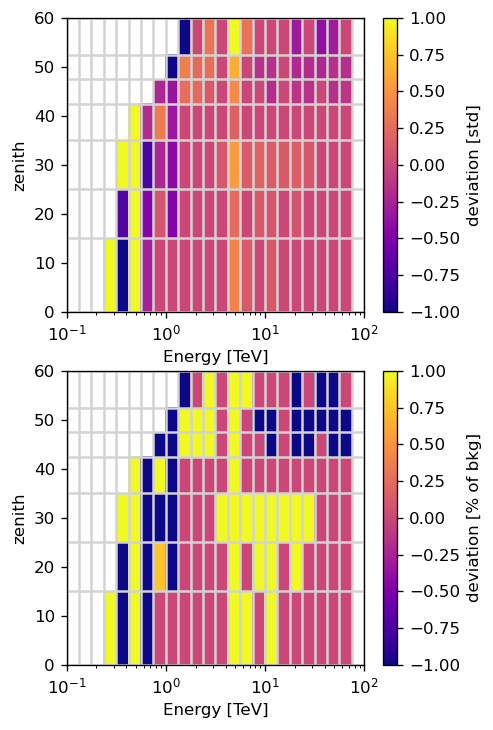

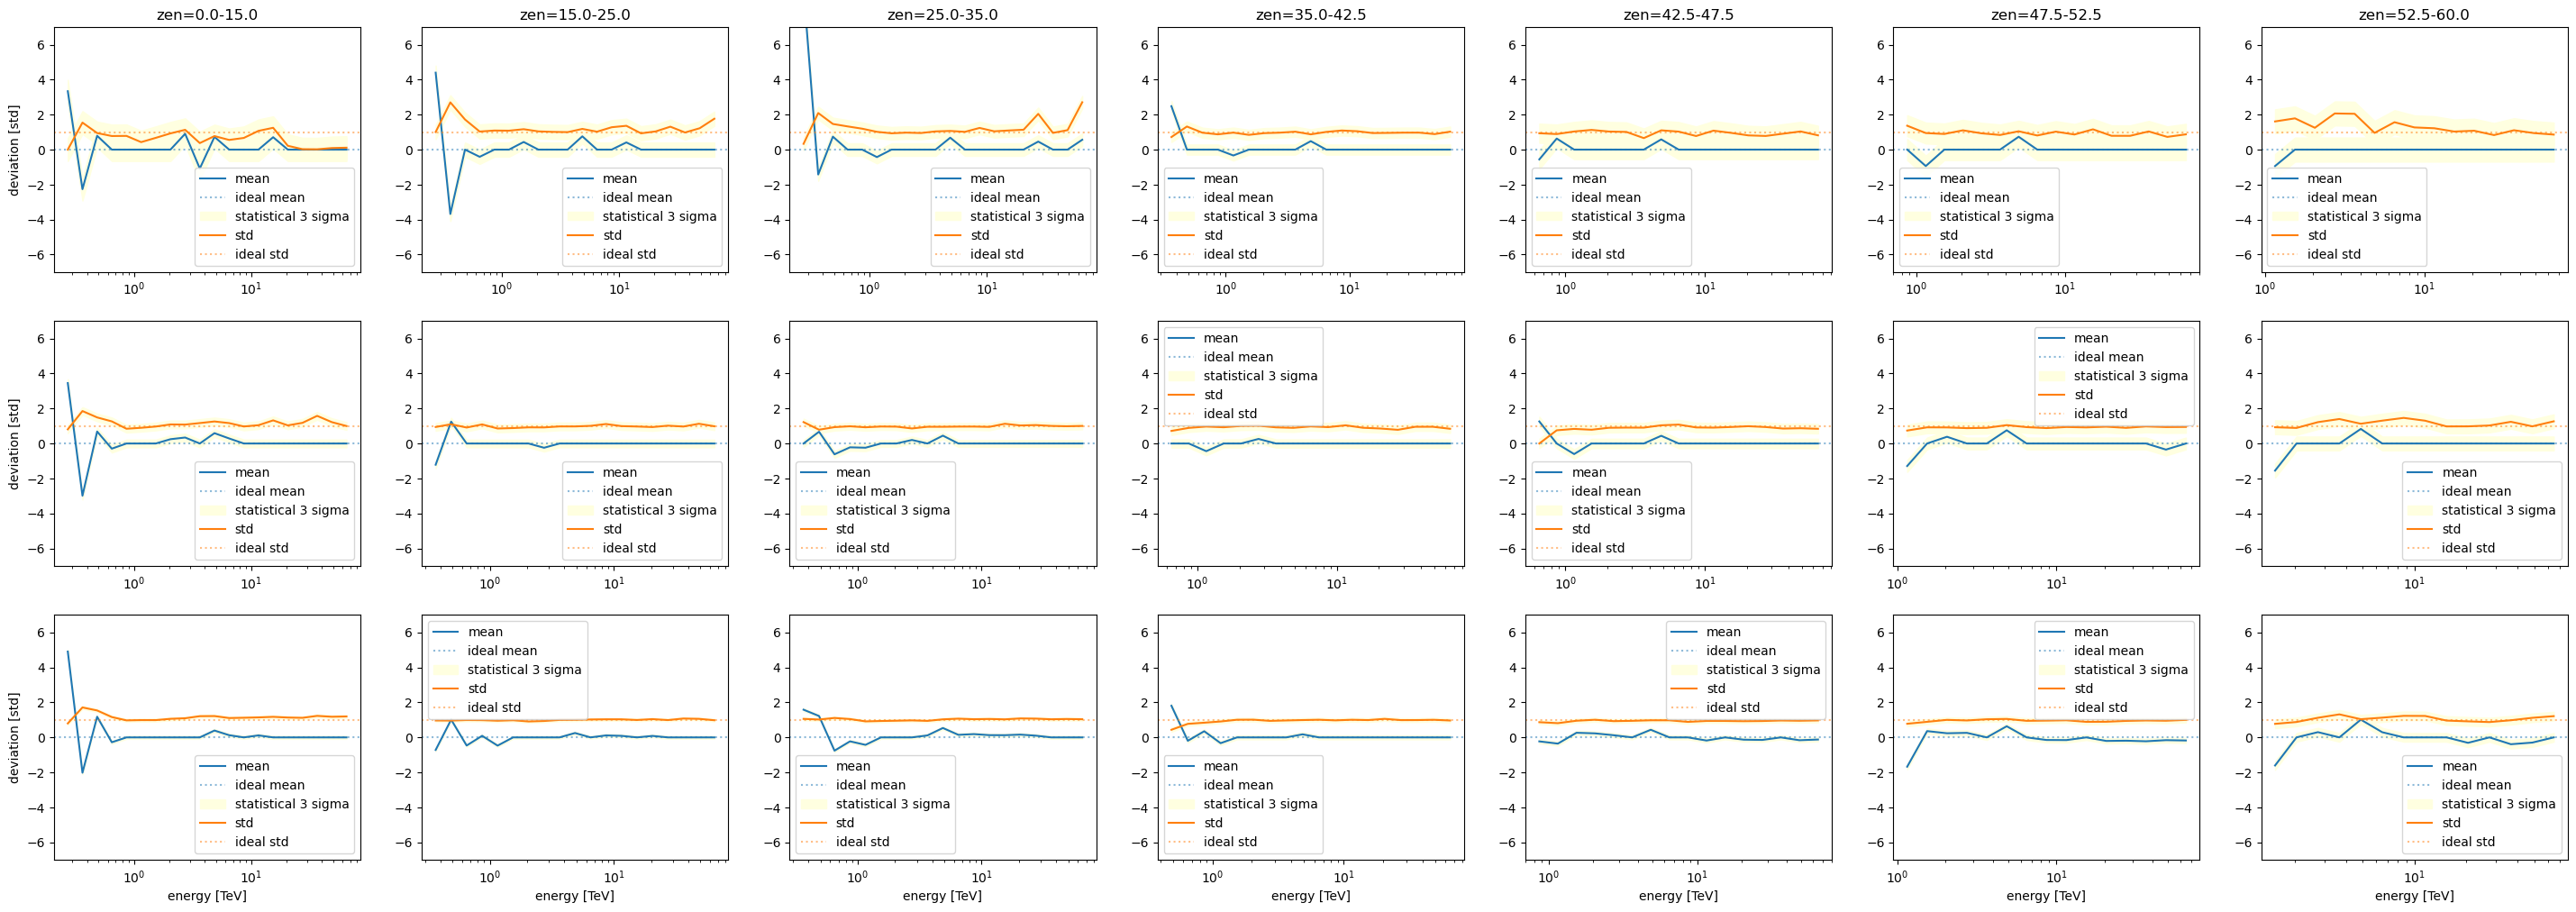

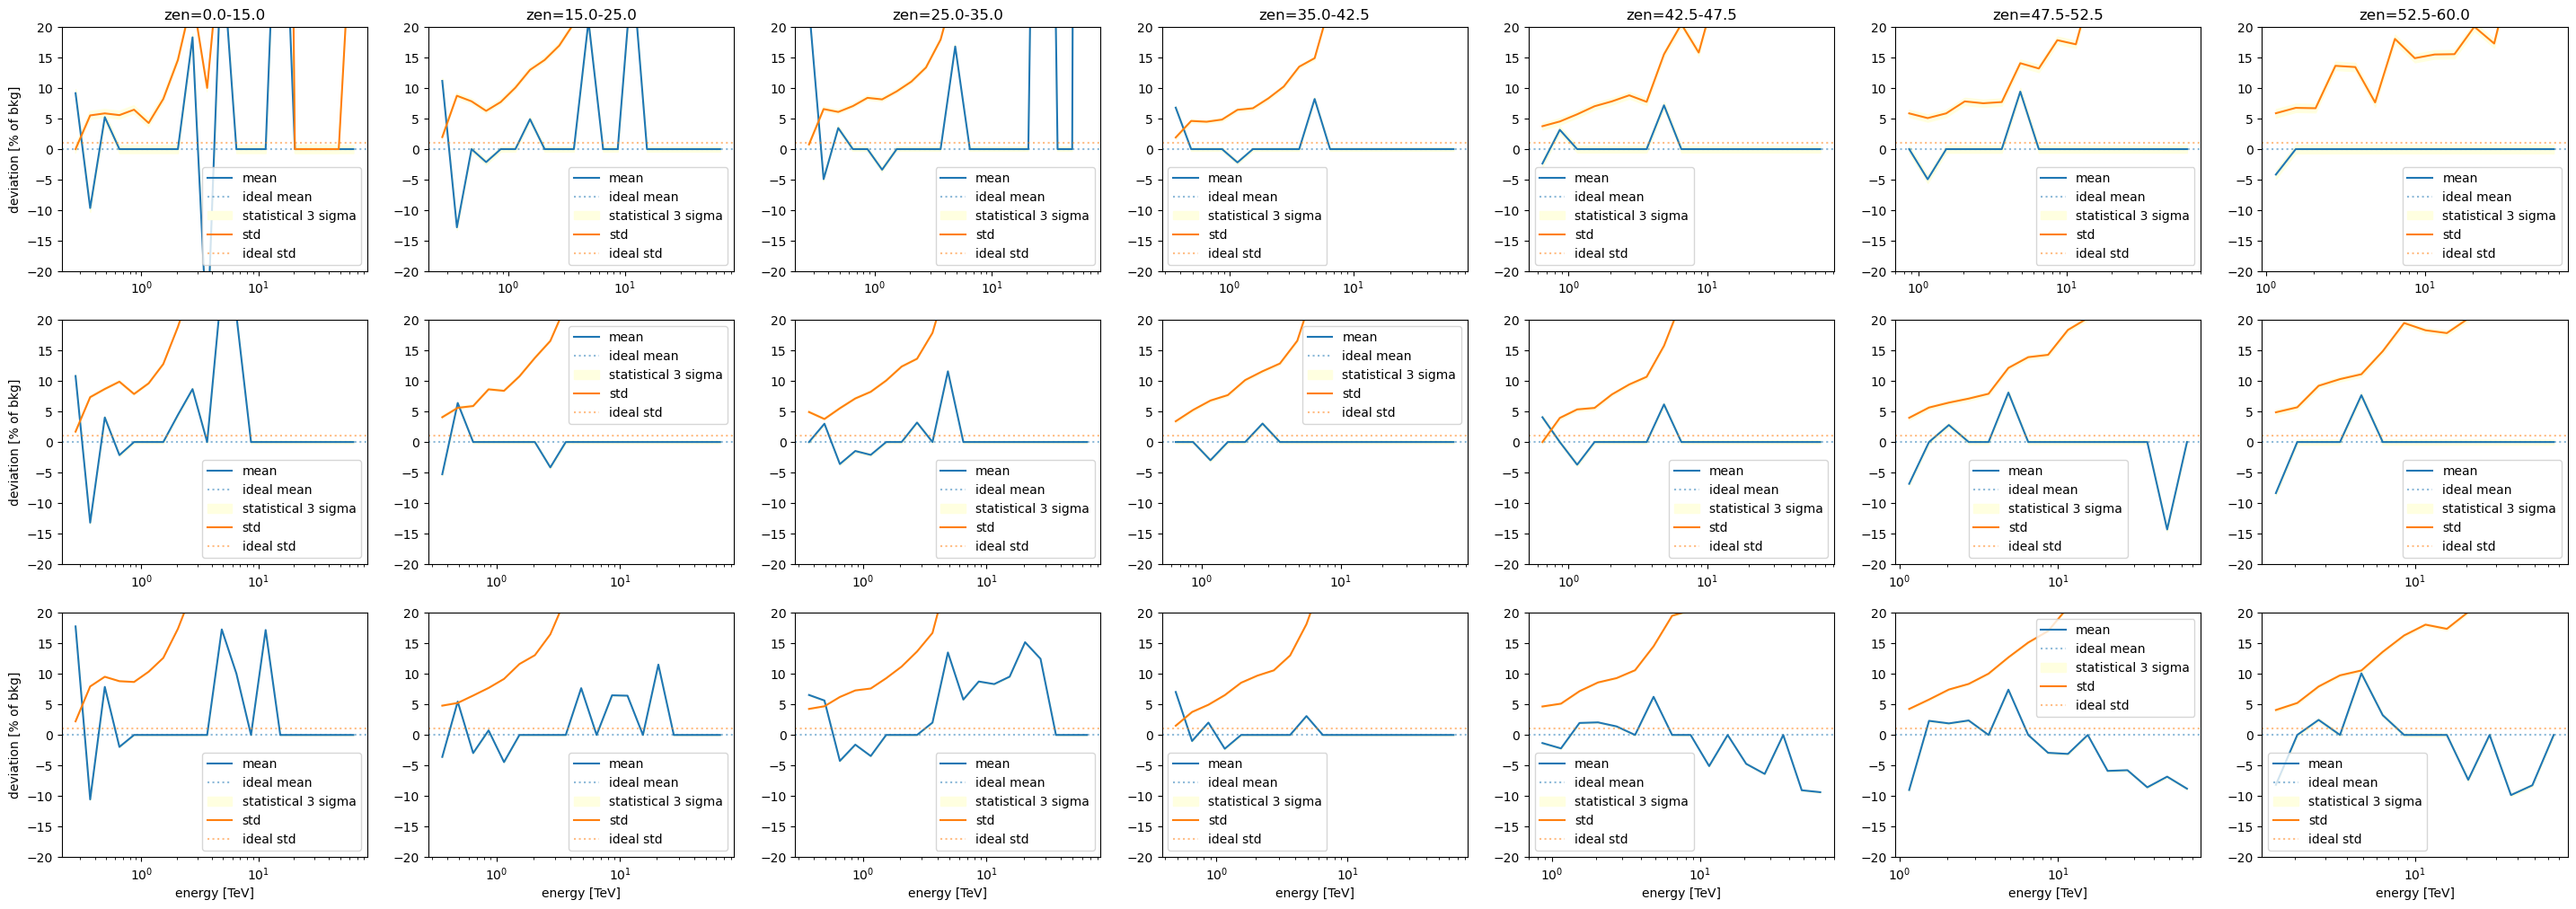

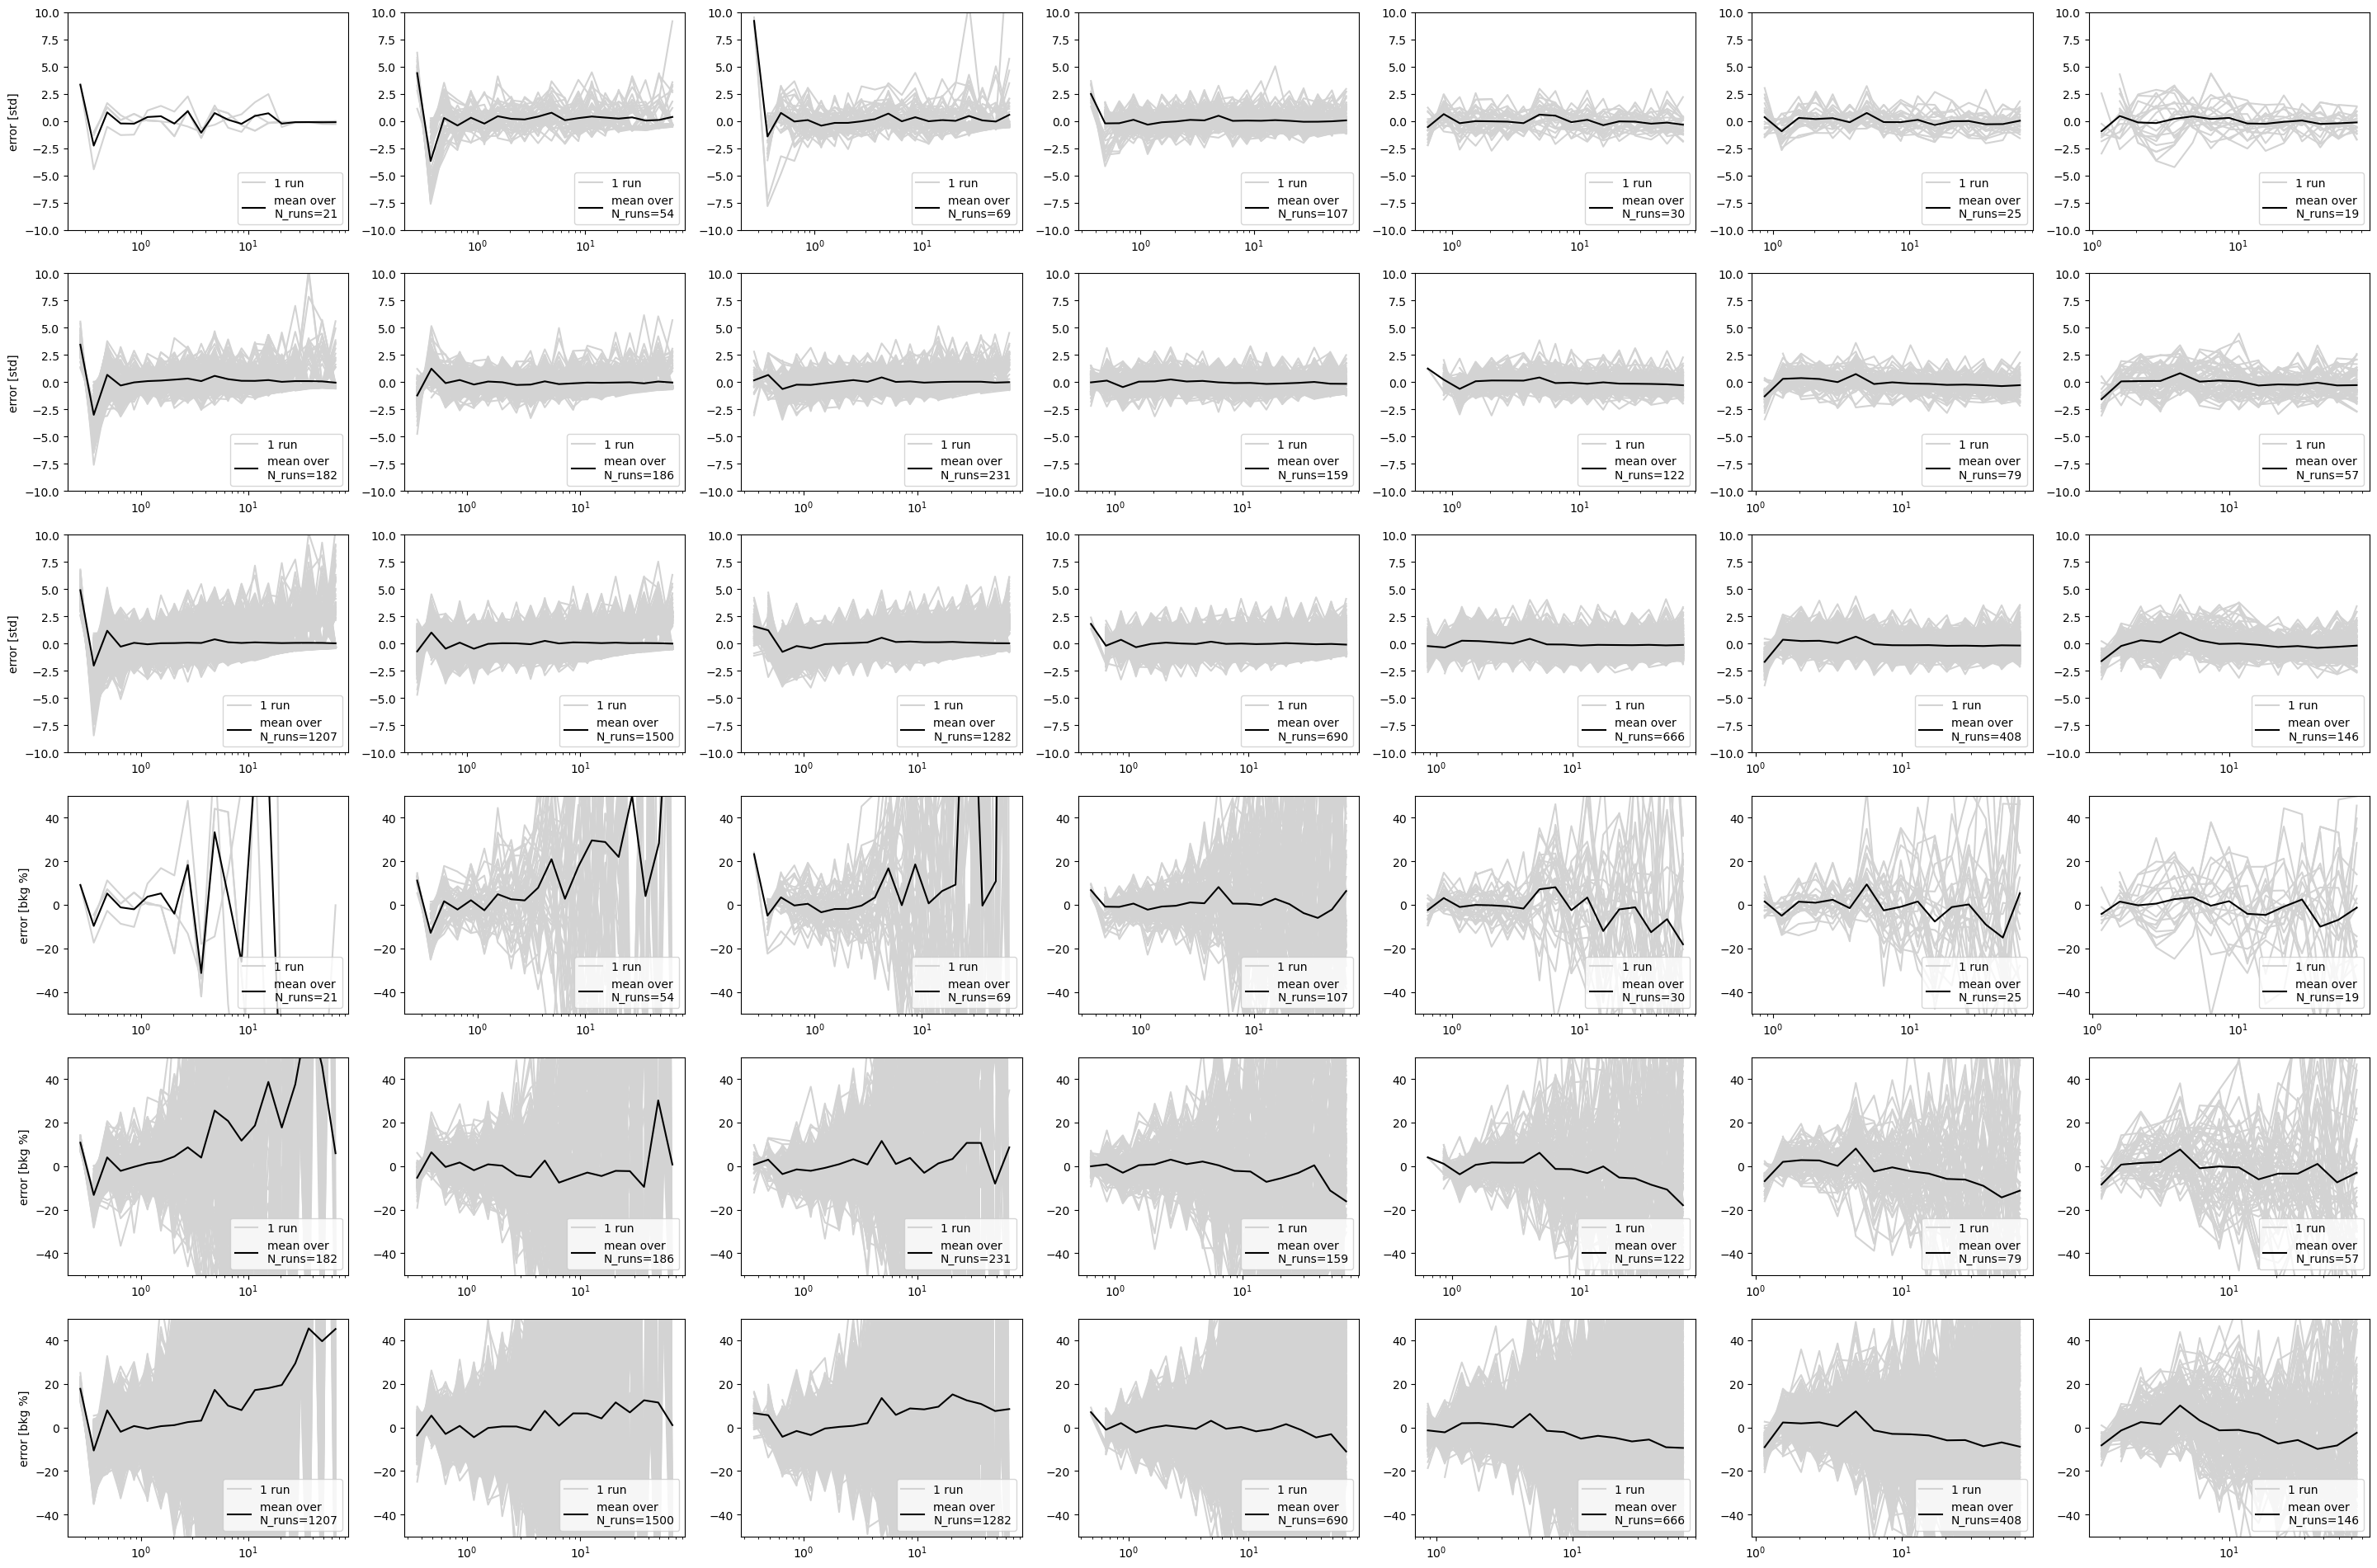

In [31]:
plot_lookup_table(er_est)
plot_mean_std(N_est, er_est, std_est)
plot_gray_curves(info, error_std, error_percentage)

there are 0/7260 with problems


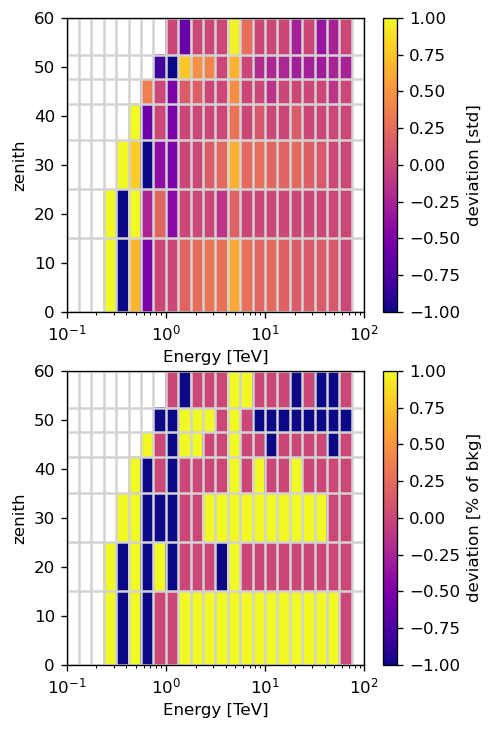

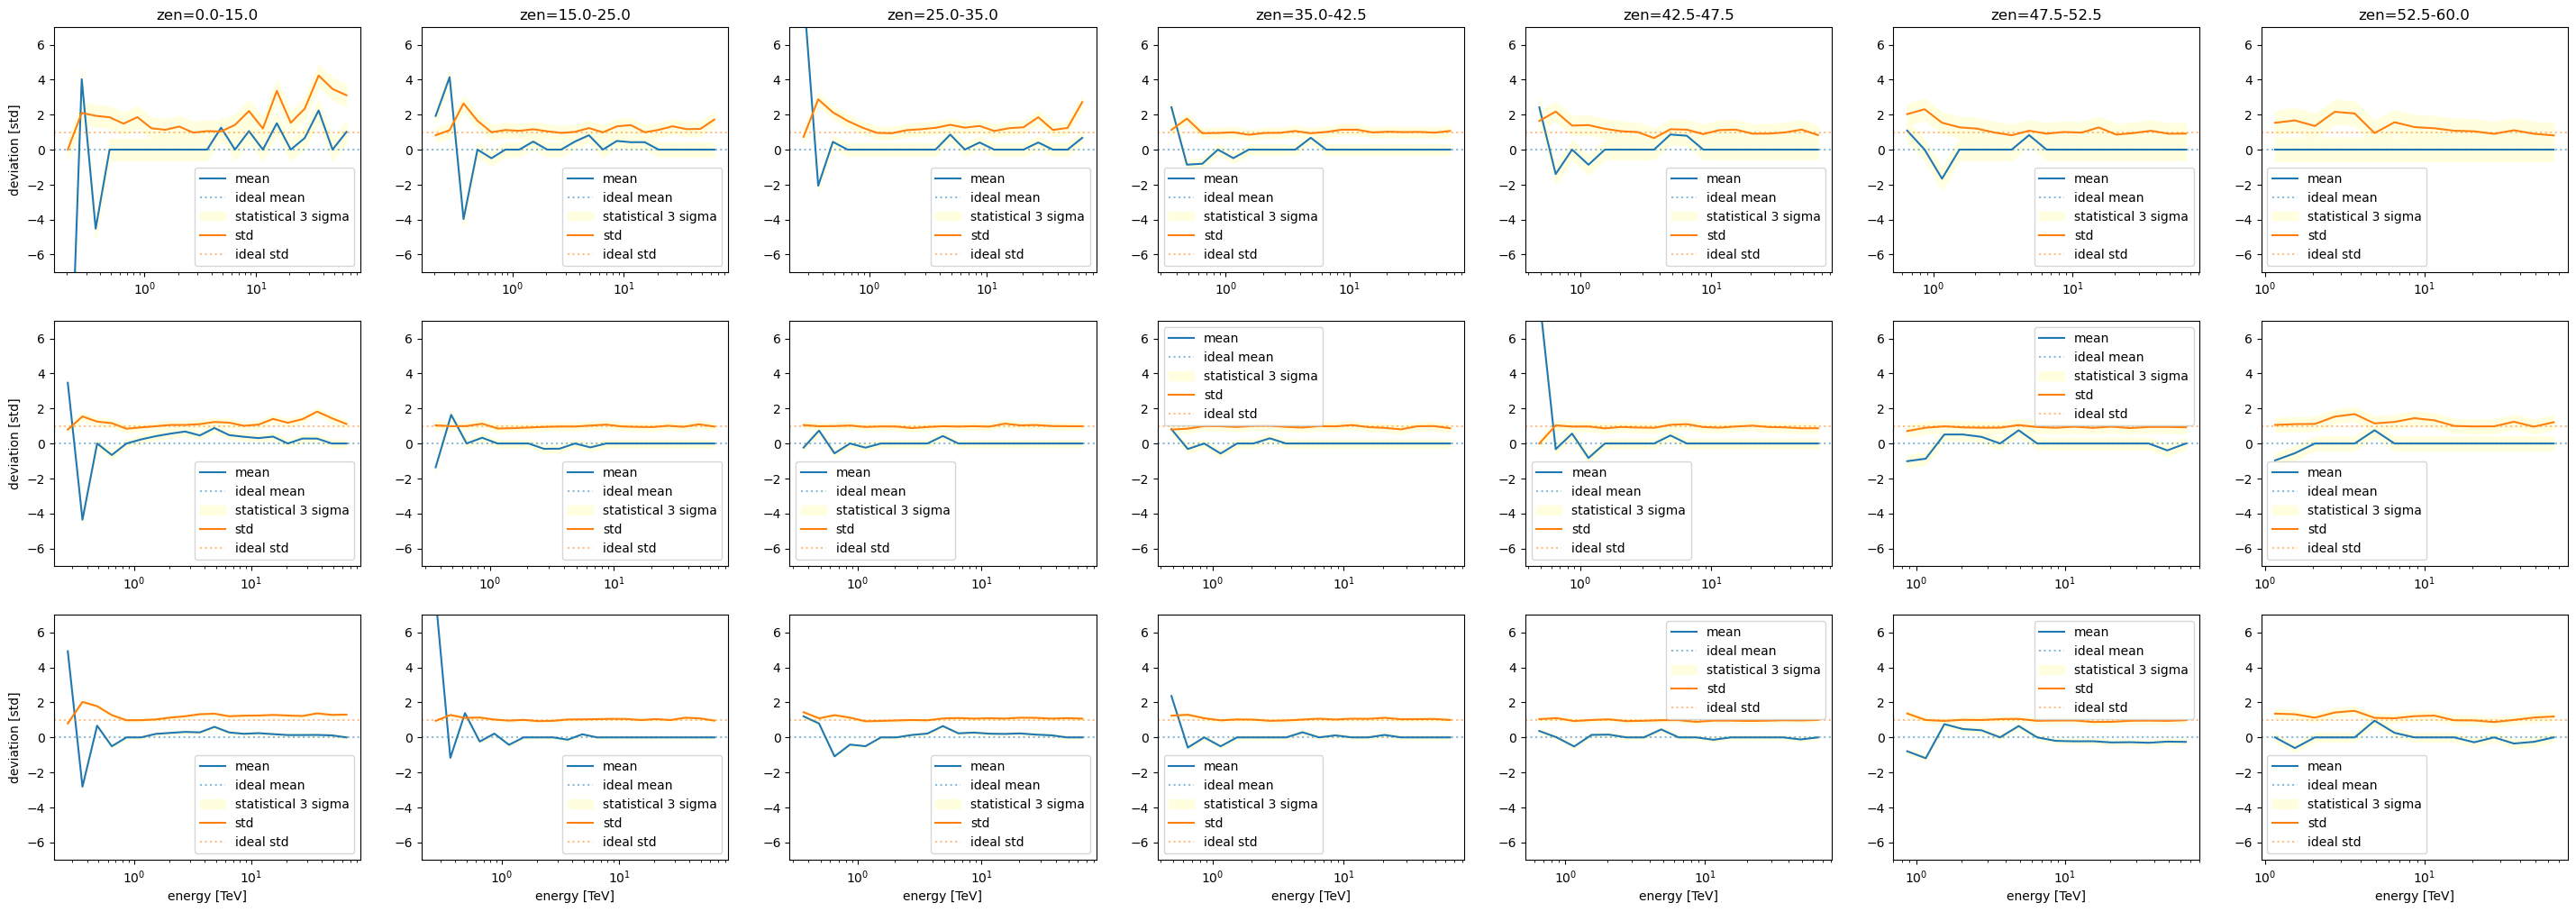

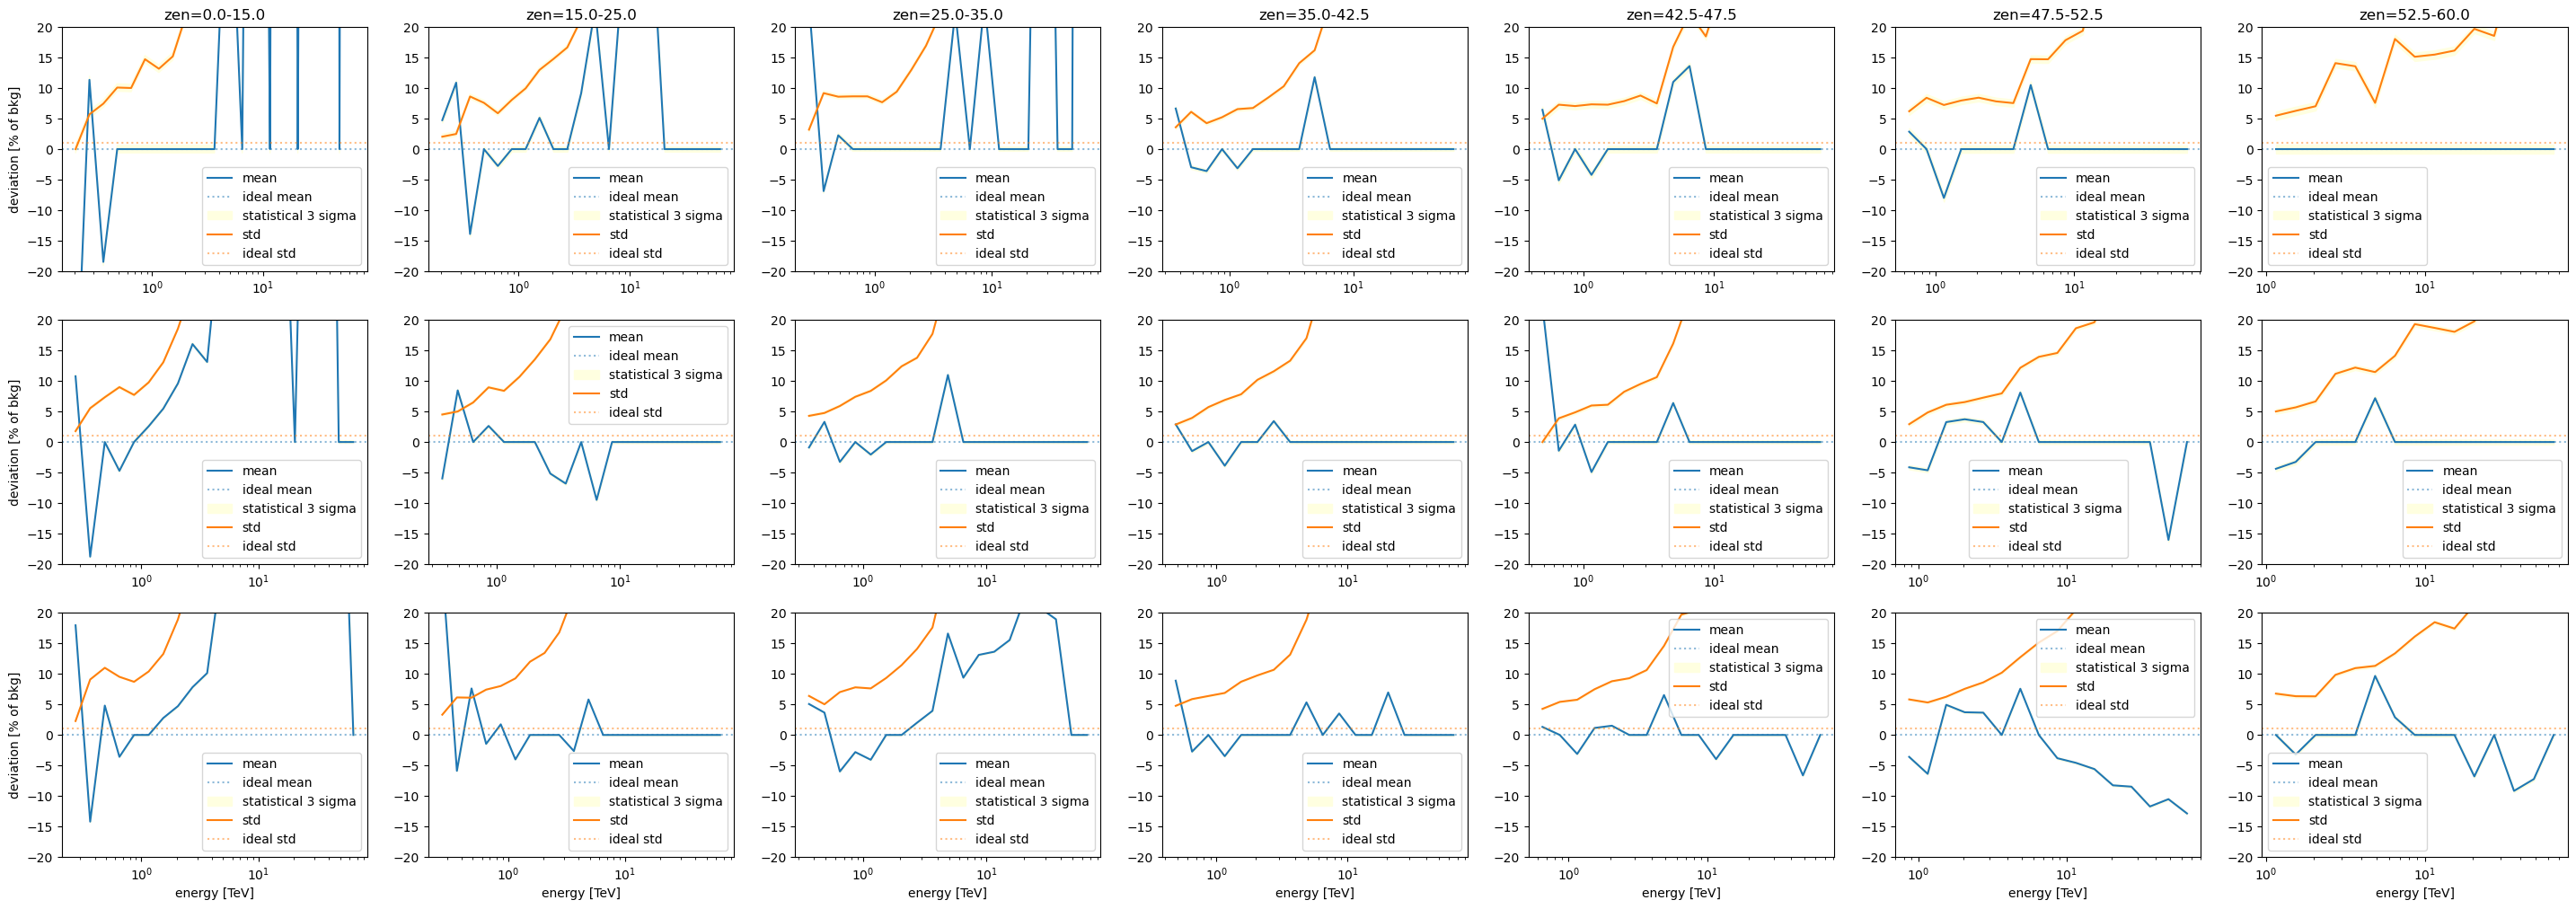

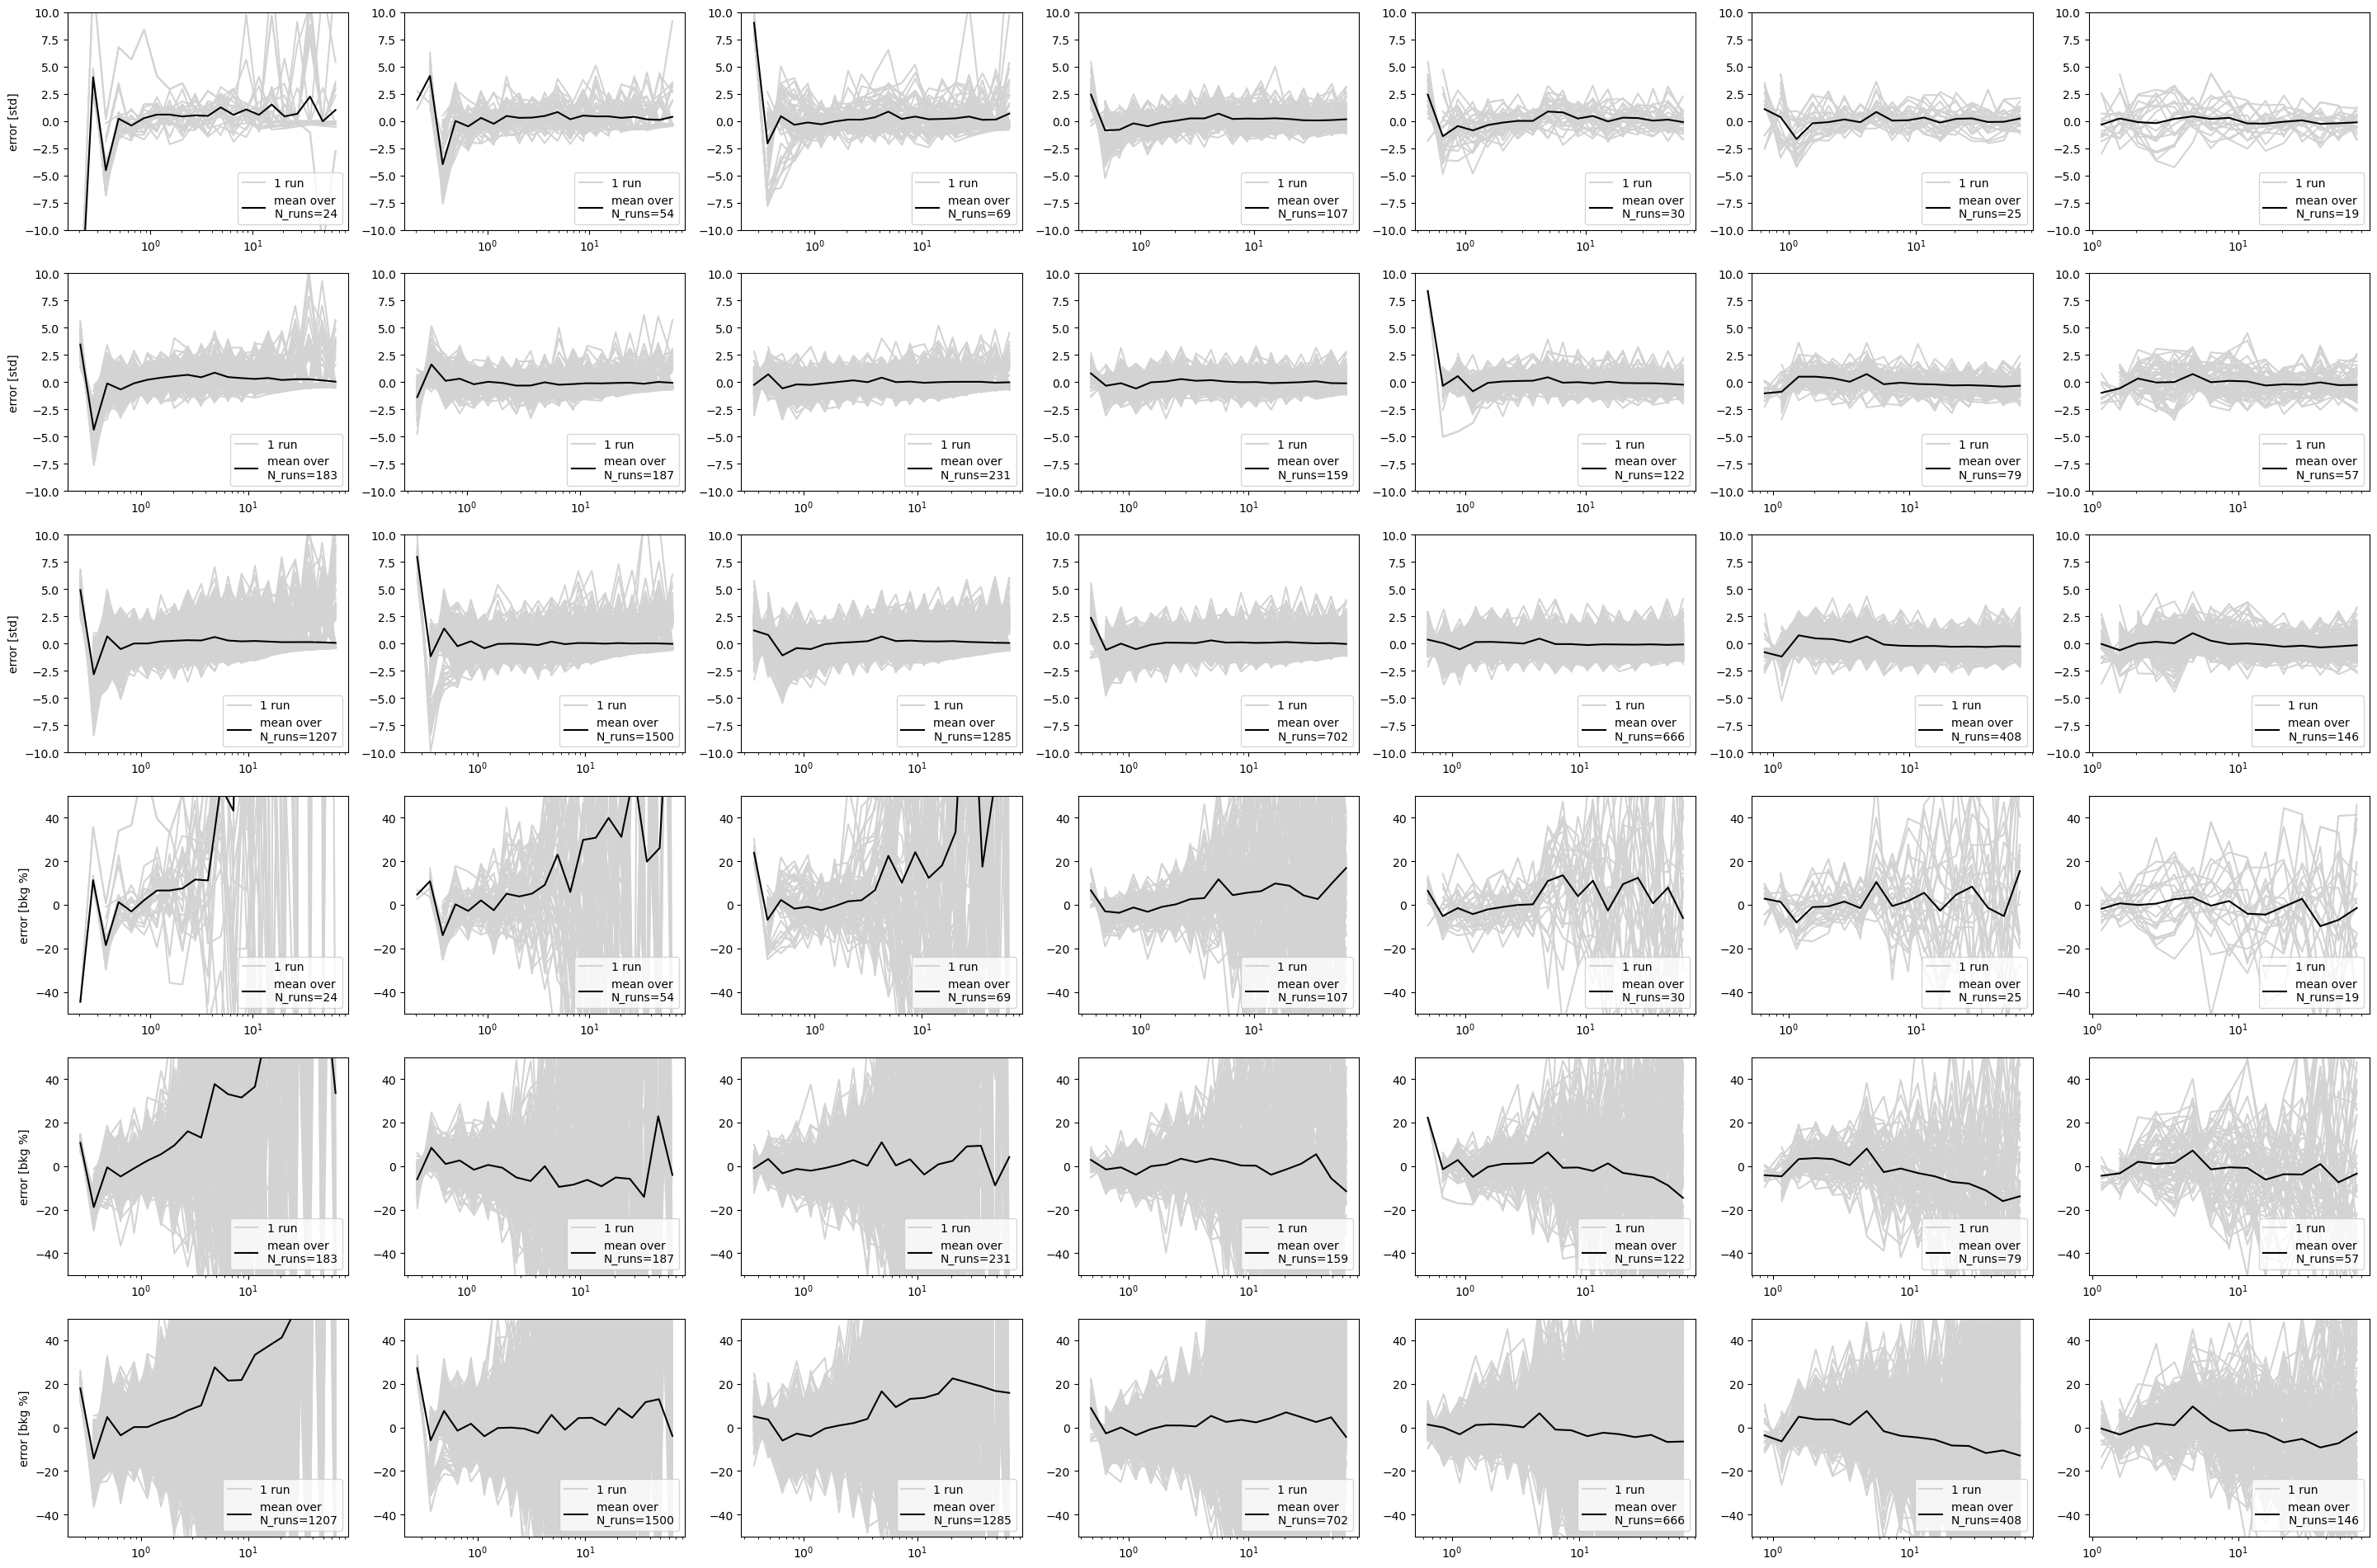

In [32]:
hessera = 'hess1'

muoneff_flag = True
edisp_flag = False
aeff_flag = True
bkg_peak_flag = False

info, error_std, error_percentage = get_results(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)
saving_model(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag, er_est)

plot_lookup_table(er_est)
plot_mean_std(N_est, er_est, std_est)
plot_gray_curves(info, error_std, error_percentage)

there are 0/1235 with problems
no runs for zen=0, model=B
no runs for zen=0, model=D
no runs for zen=1, model=B
no runs for zen=1, model=D
no runs for zen=2, model=B
no runs for zen=2, model=D
no runs for zen=3, model=B
no runs for zen=3, model=D
no runs for zen=4, model=B
no runs for zen=4, model=D
no runs for zen=5, model=B
no runs for zen=5, model=D
no runs for zen=6, model=B
no runs for zen=6, model=D


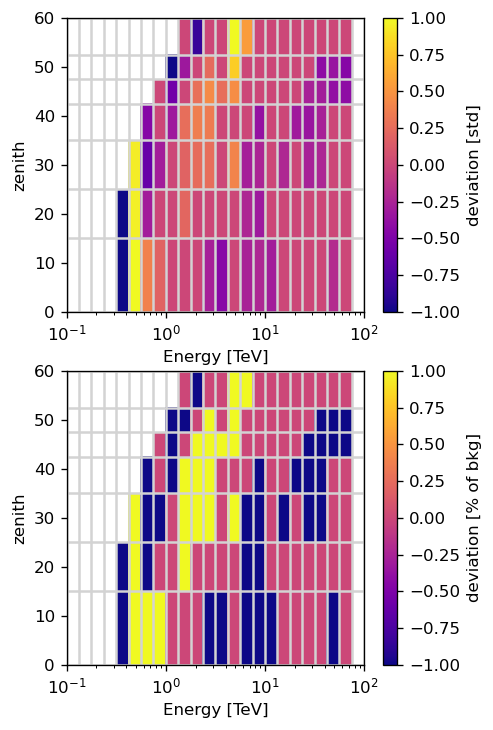

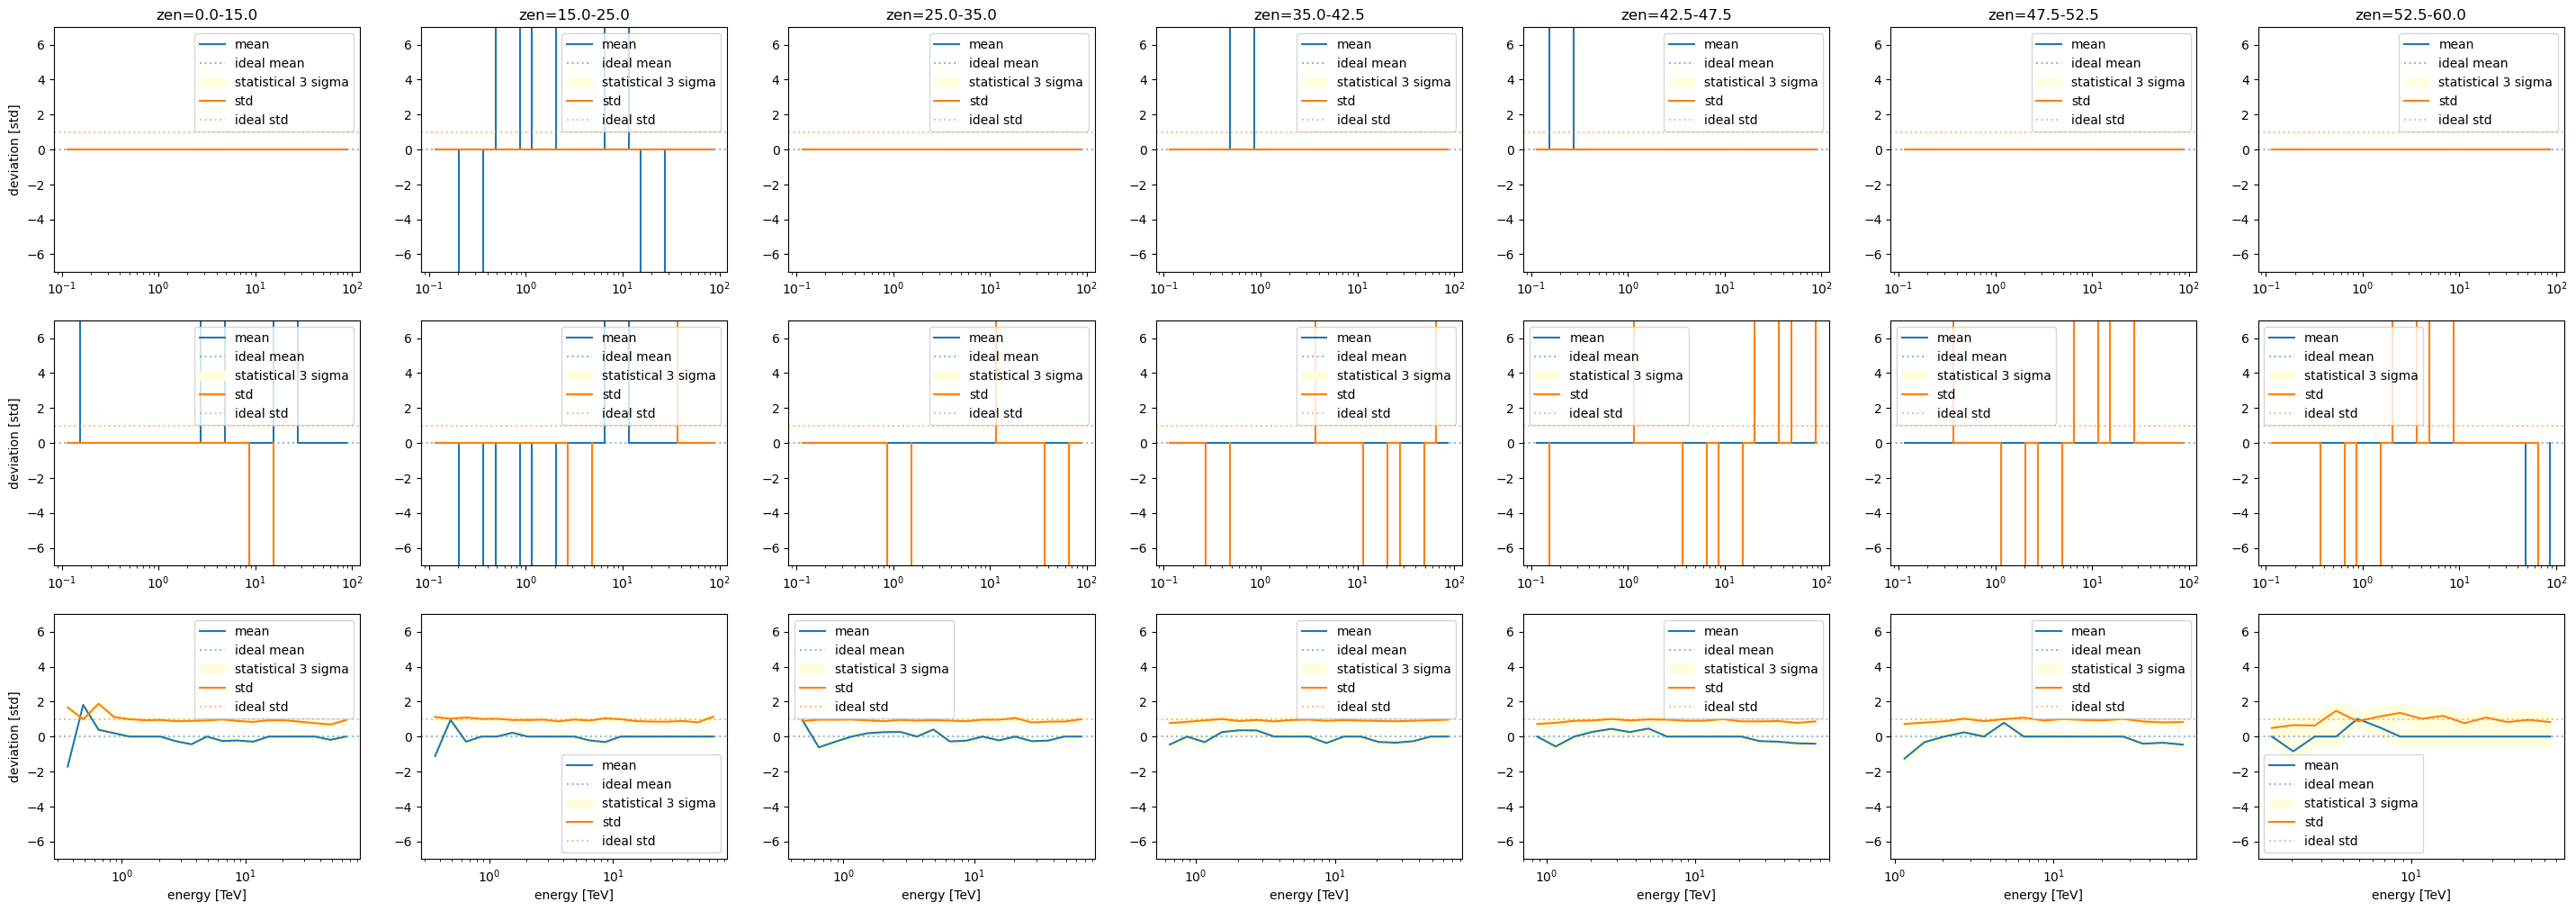

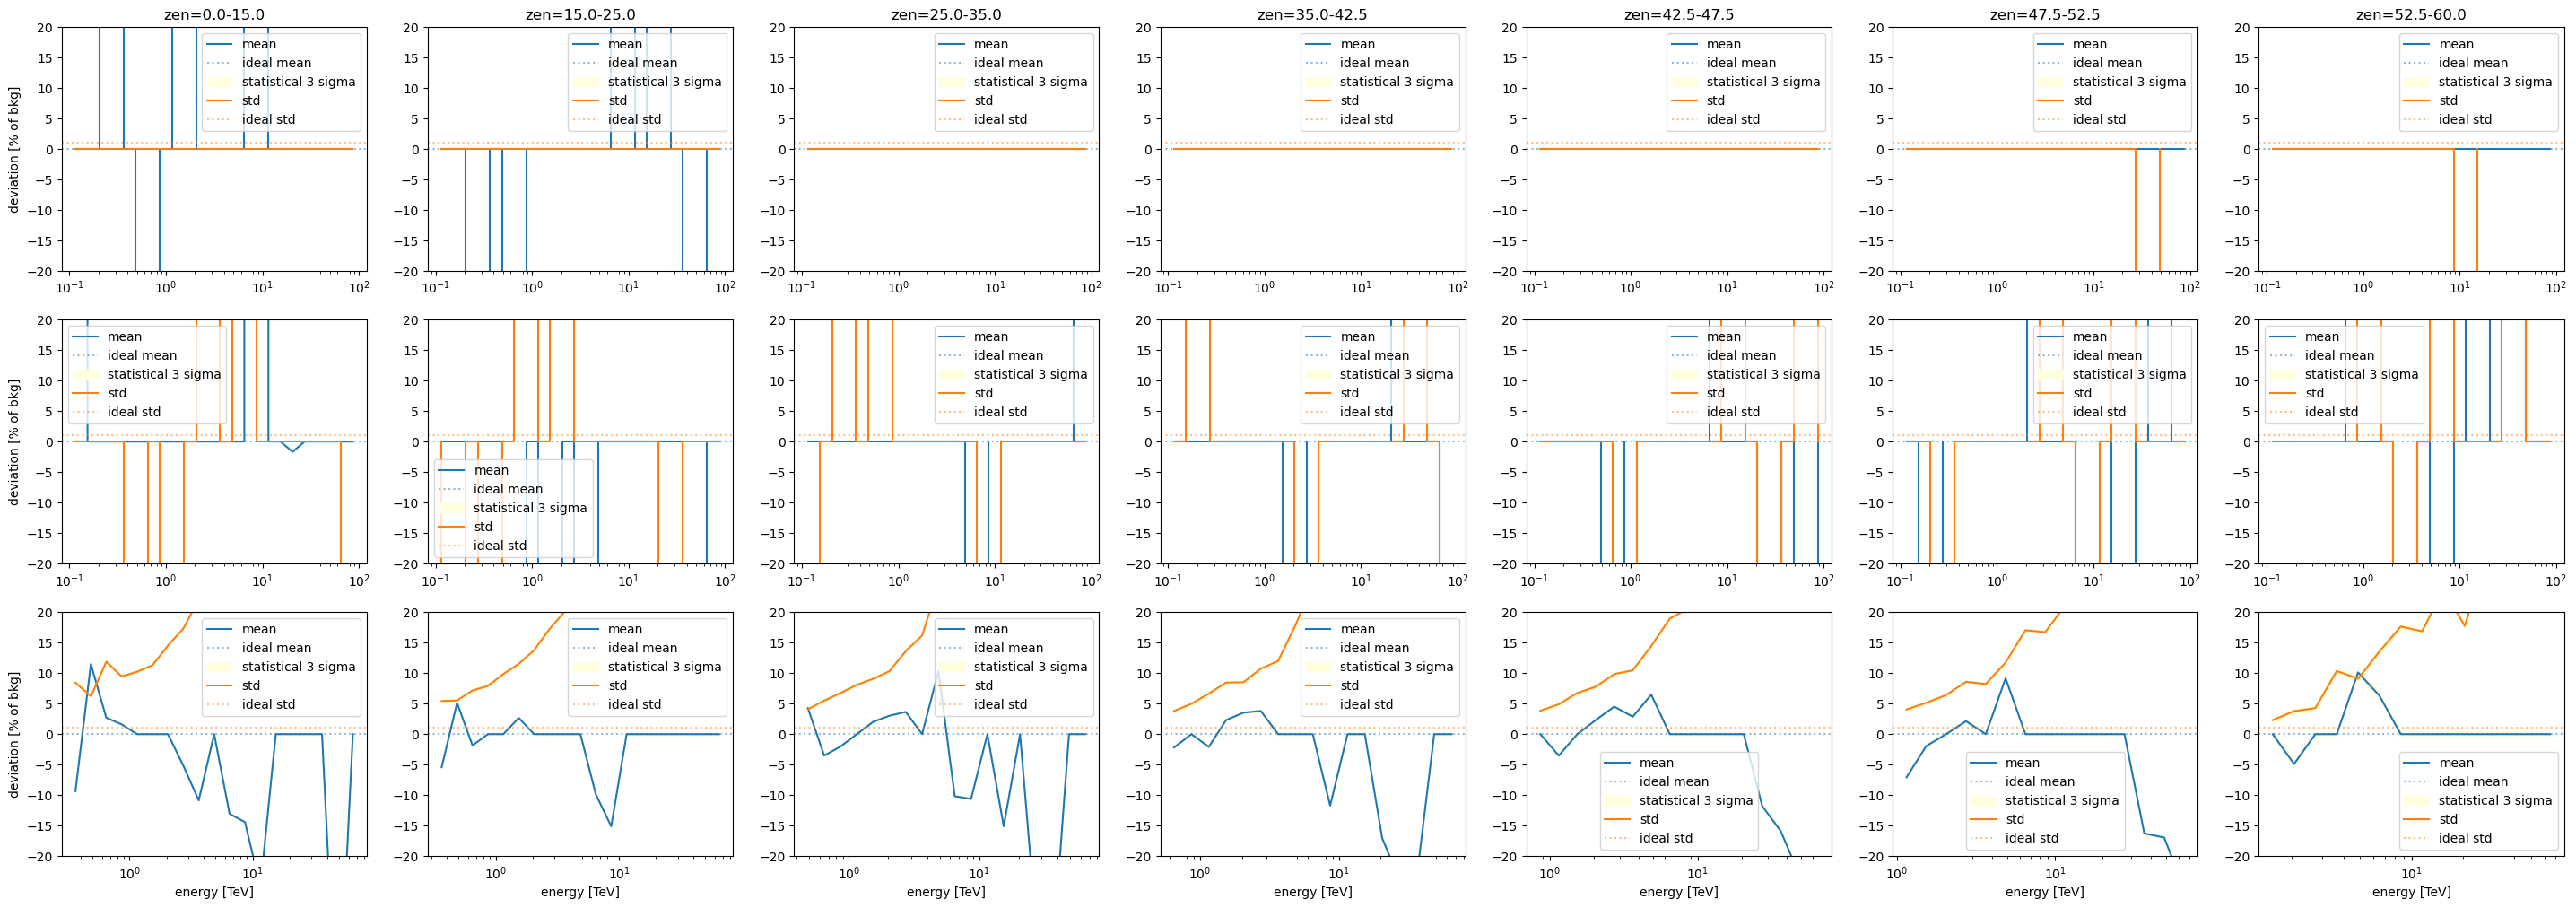

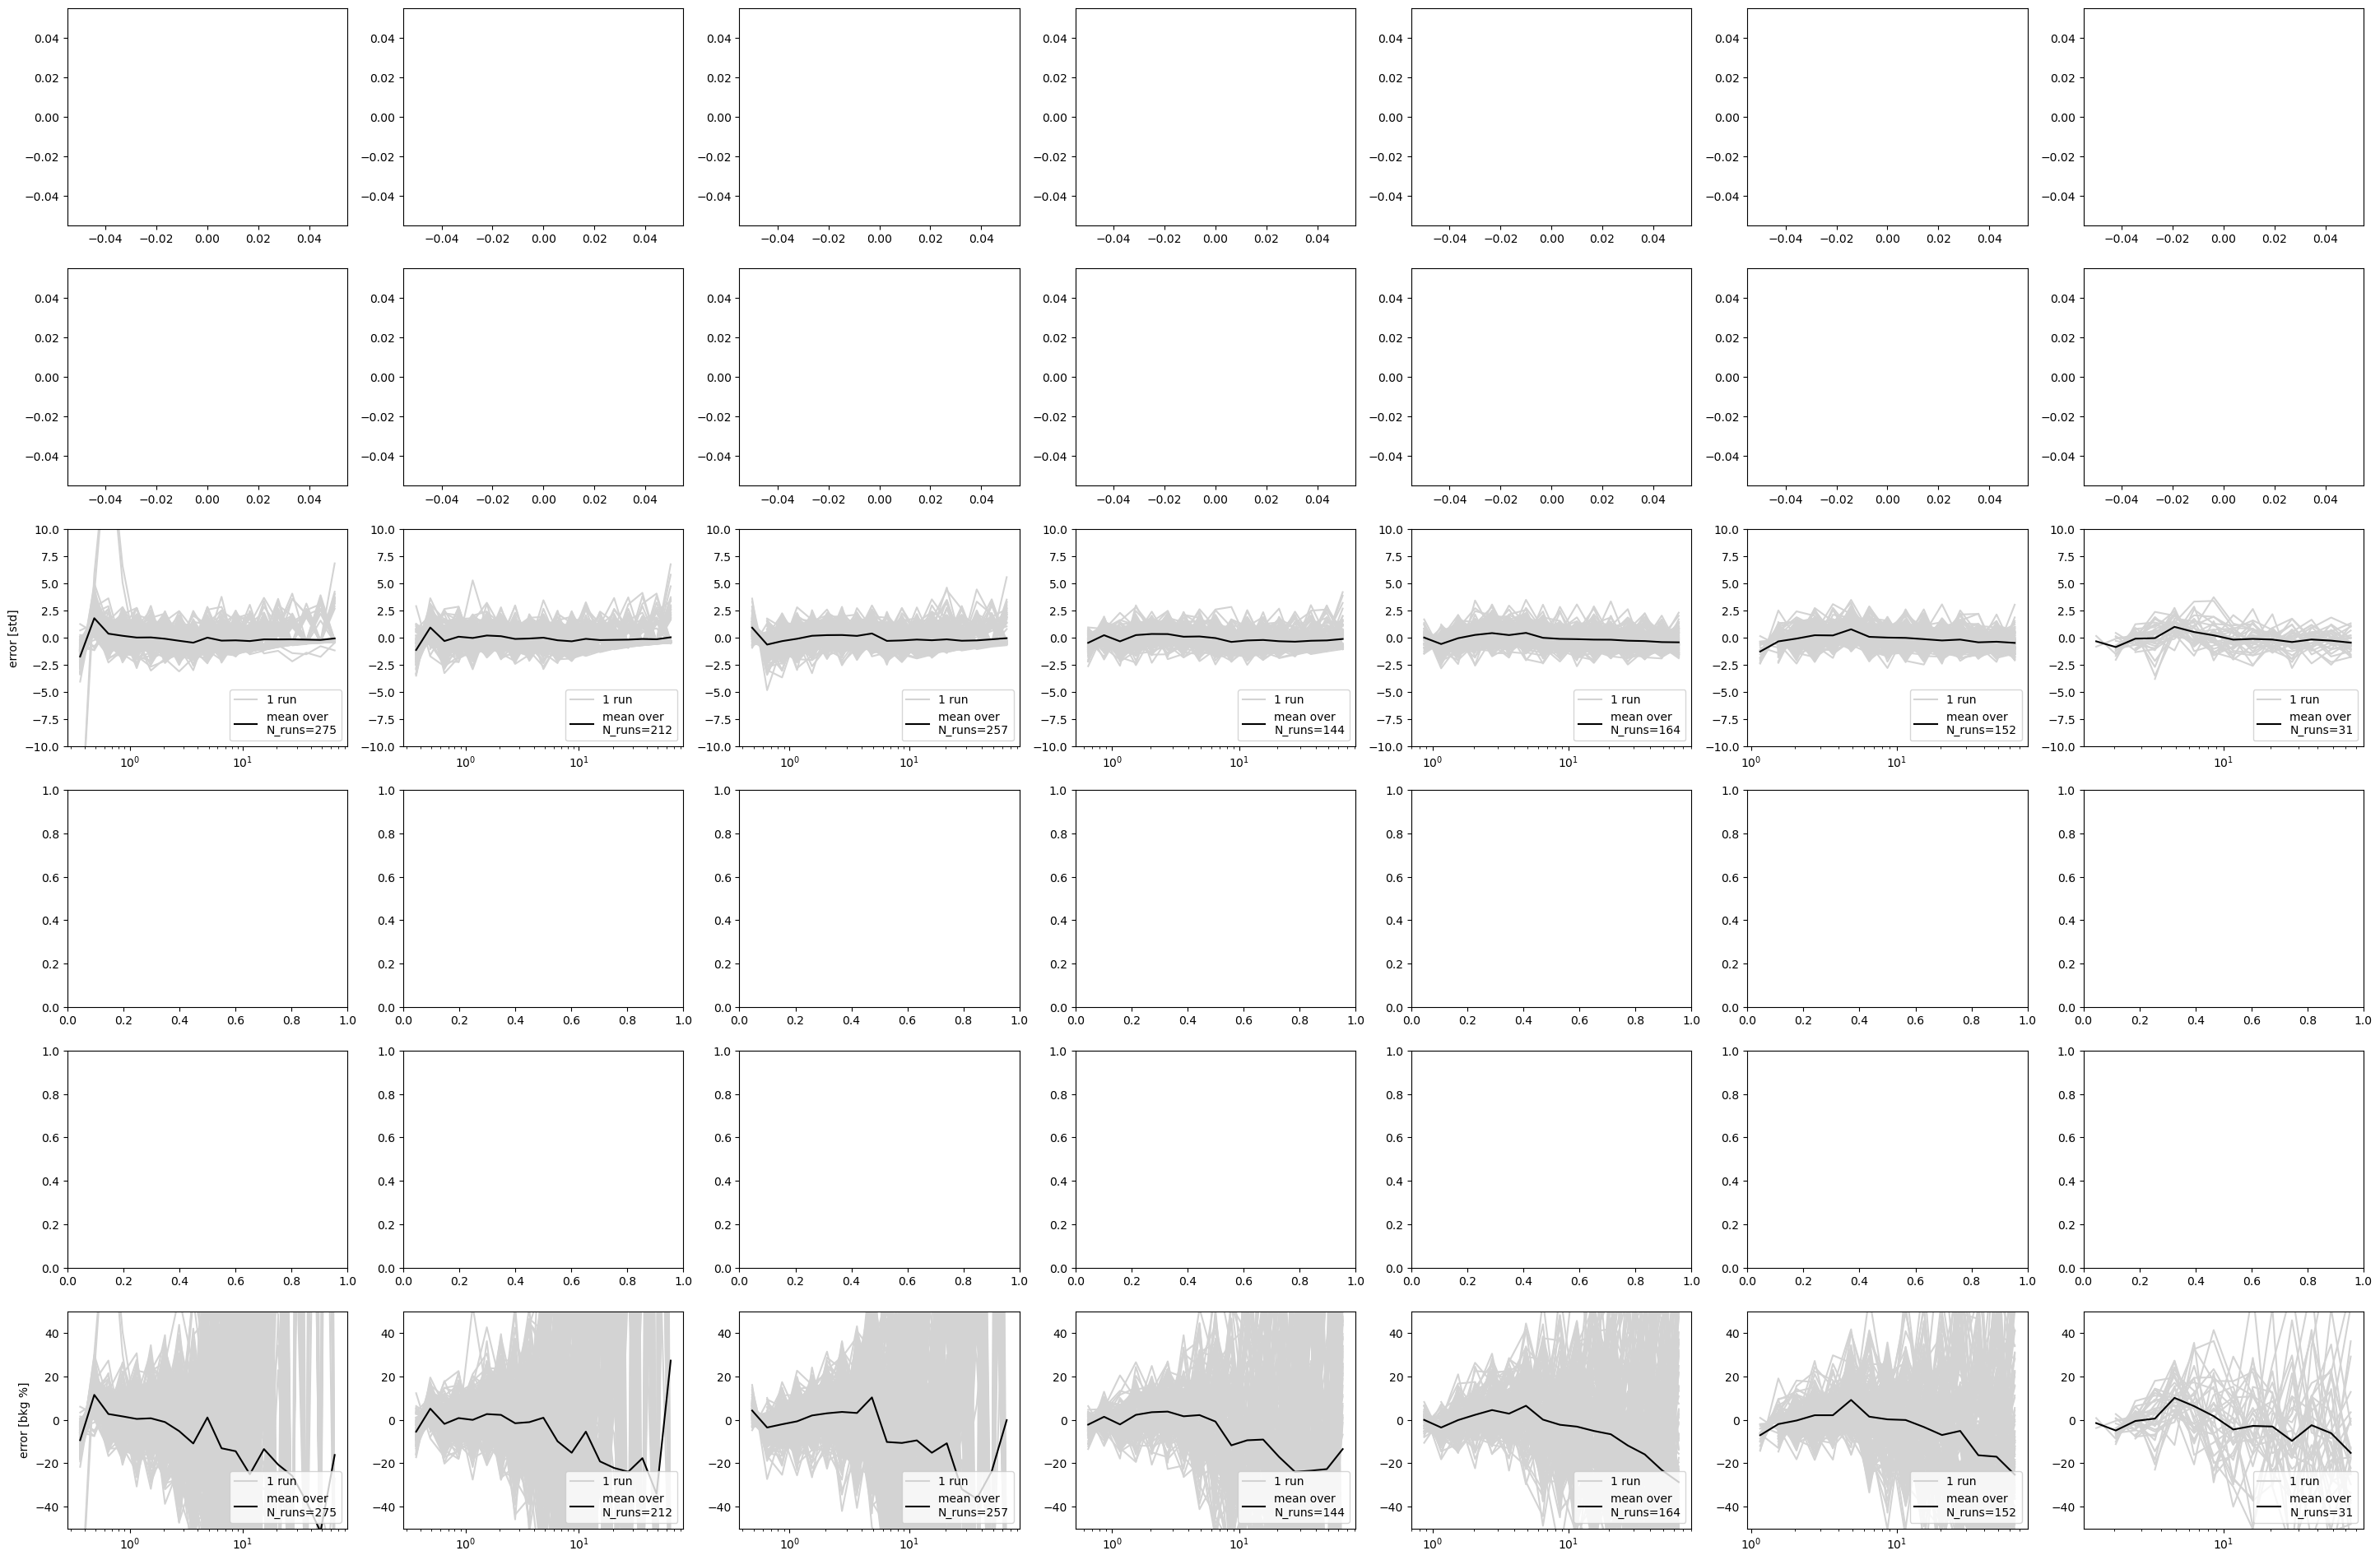

In [10]:
hessera = 'hess2'

muoneff_flag = True
edisp_flag = True
aeff_flag = True
bkg_peak_flag = True

info, error_std, error_percentage = get_results(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)
saving_model(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag, er_est)

plot_lookup_table(er_est)
plot_mean_std(N_est, er_est, std_est)
plot_gray_curves(info, error_std, error_percentage)

there are 0/1235 with problems
no runs for zen=0, model=B
no runs for zen=0, model=D
no runs for zen=1, model=B
no runs for zen=1, model=D
no runs for zen=2, model=B
no runs for zen=2, model=D
no runs for zen=3, model=B
no runs for zen=3, model=D
no runs for zen=4, model=B
no runs for zen=4, model=D
no runs for zen=5, model=B
no runs for zen=5, model=D
no runs for zen=6, model=B
no runs for zen=6, model=D


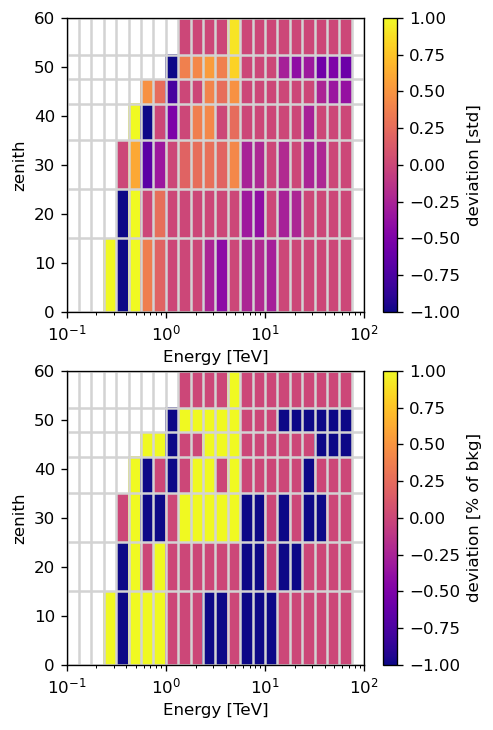

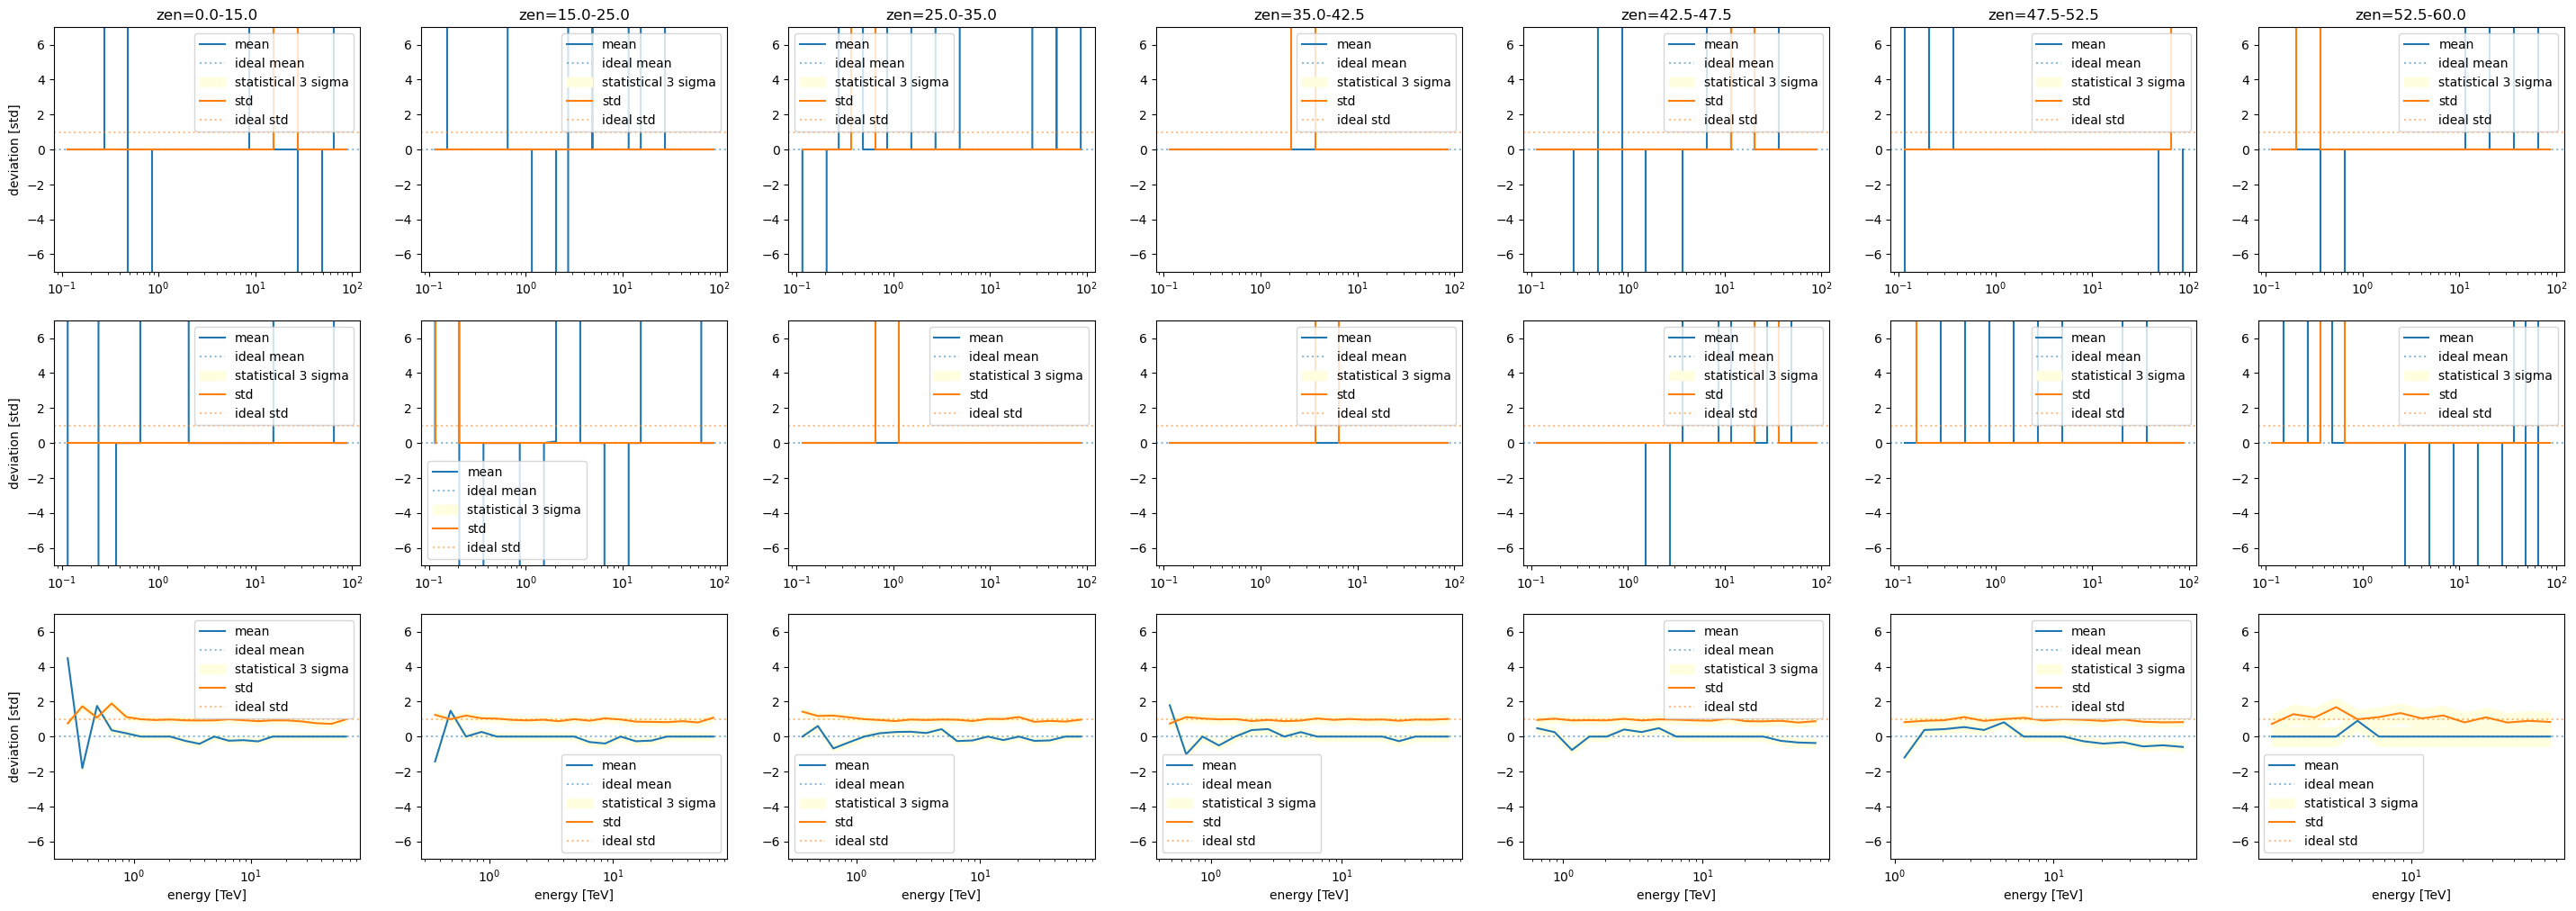

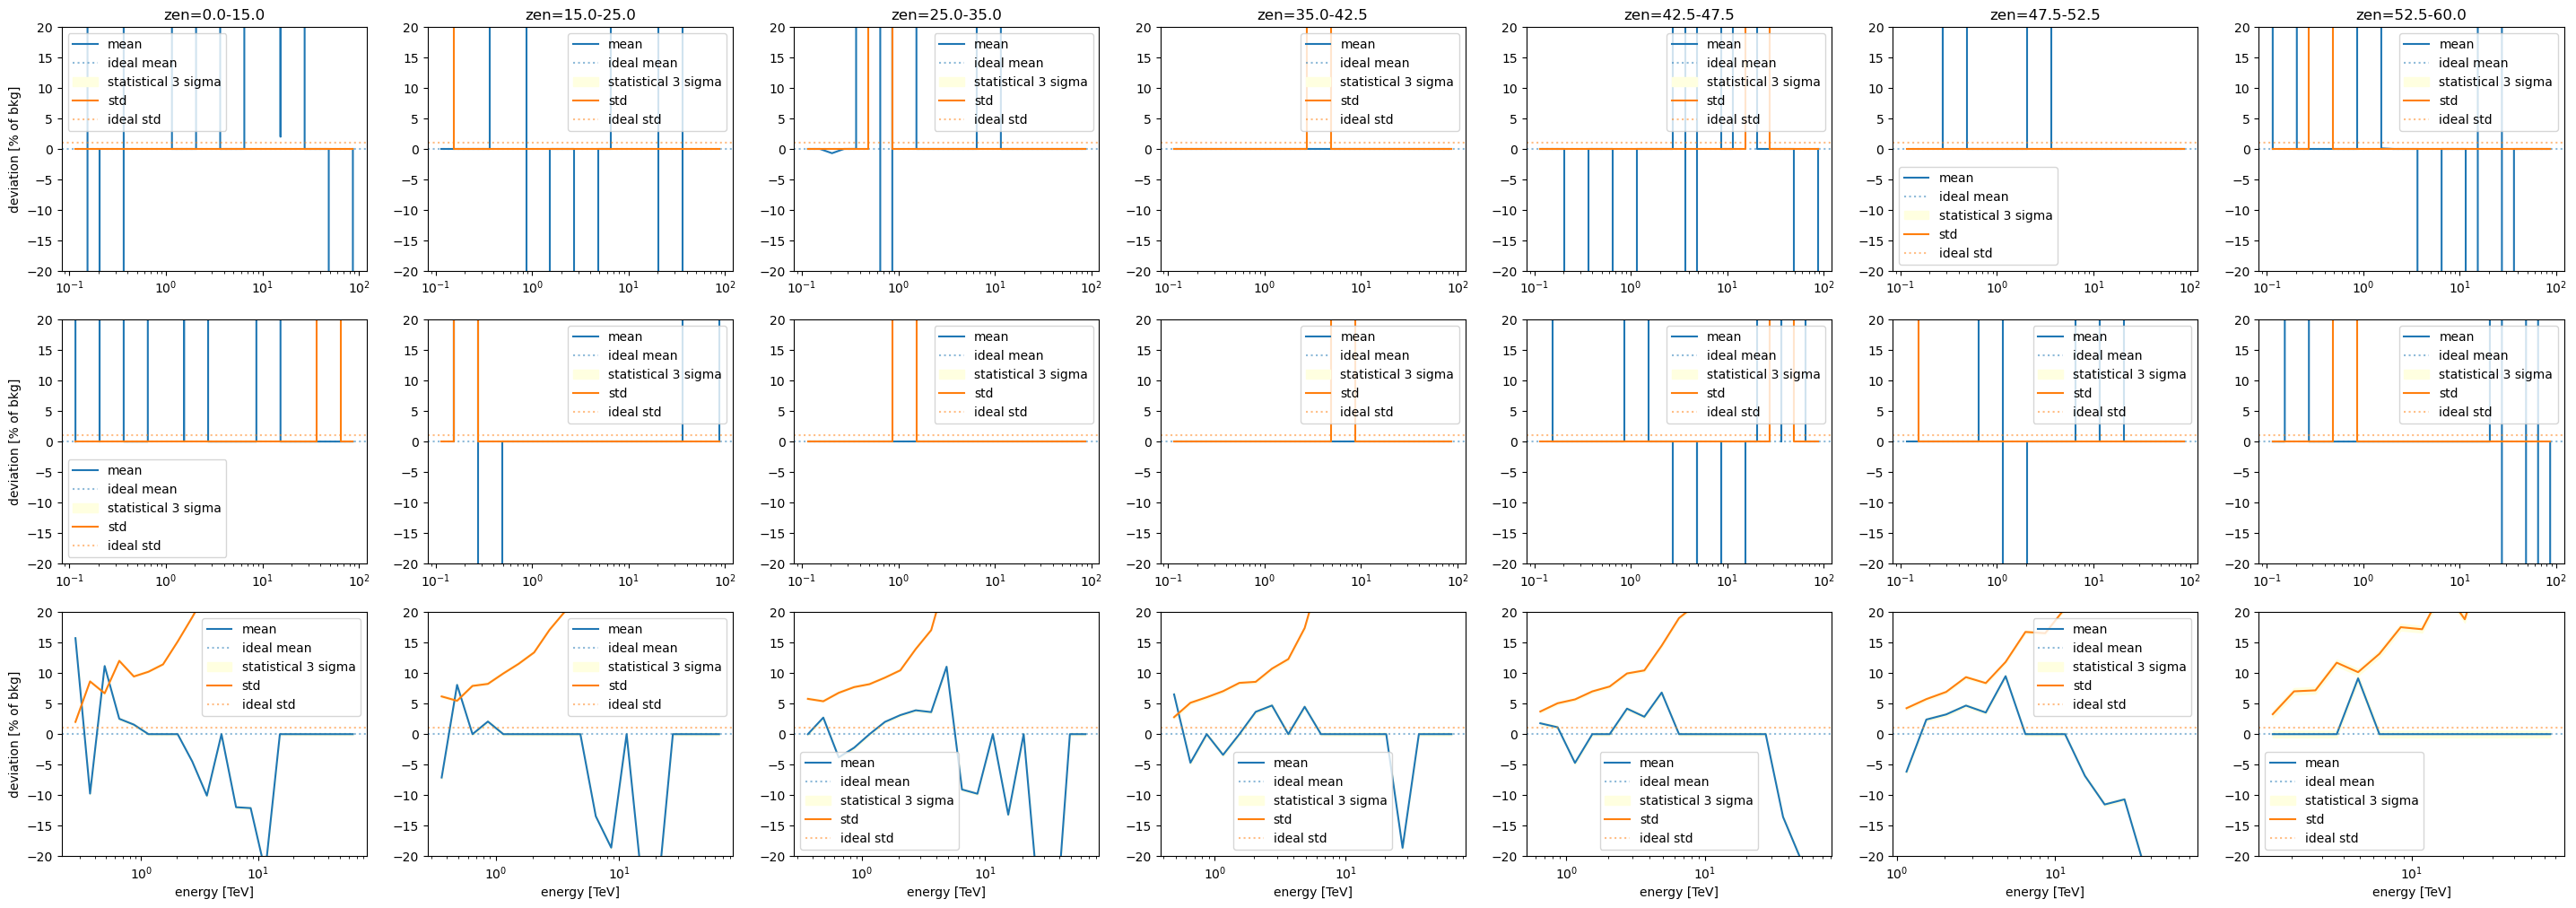

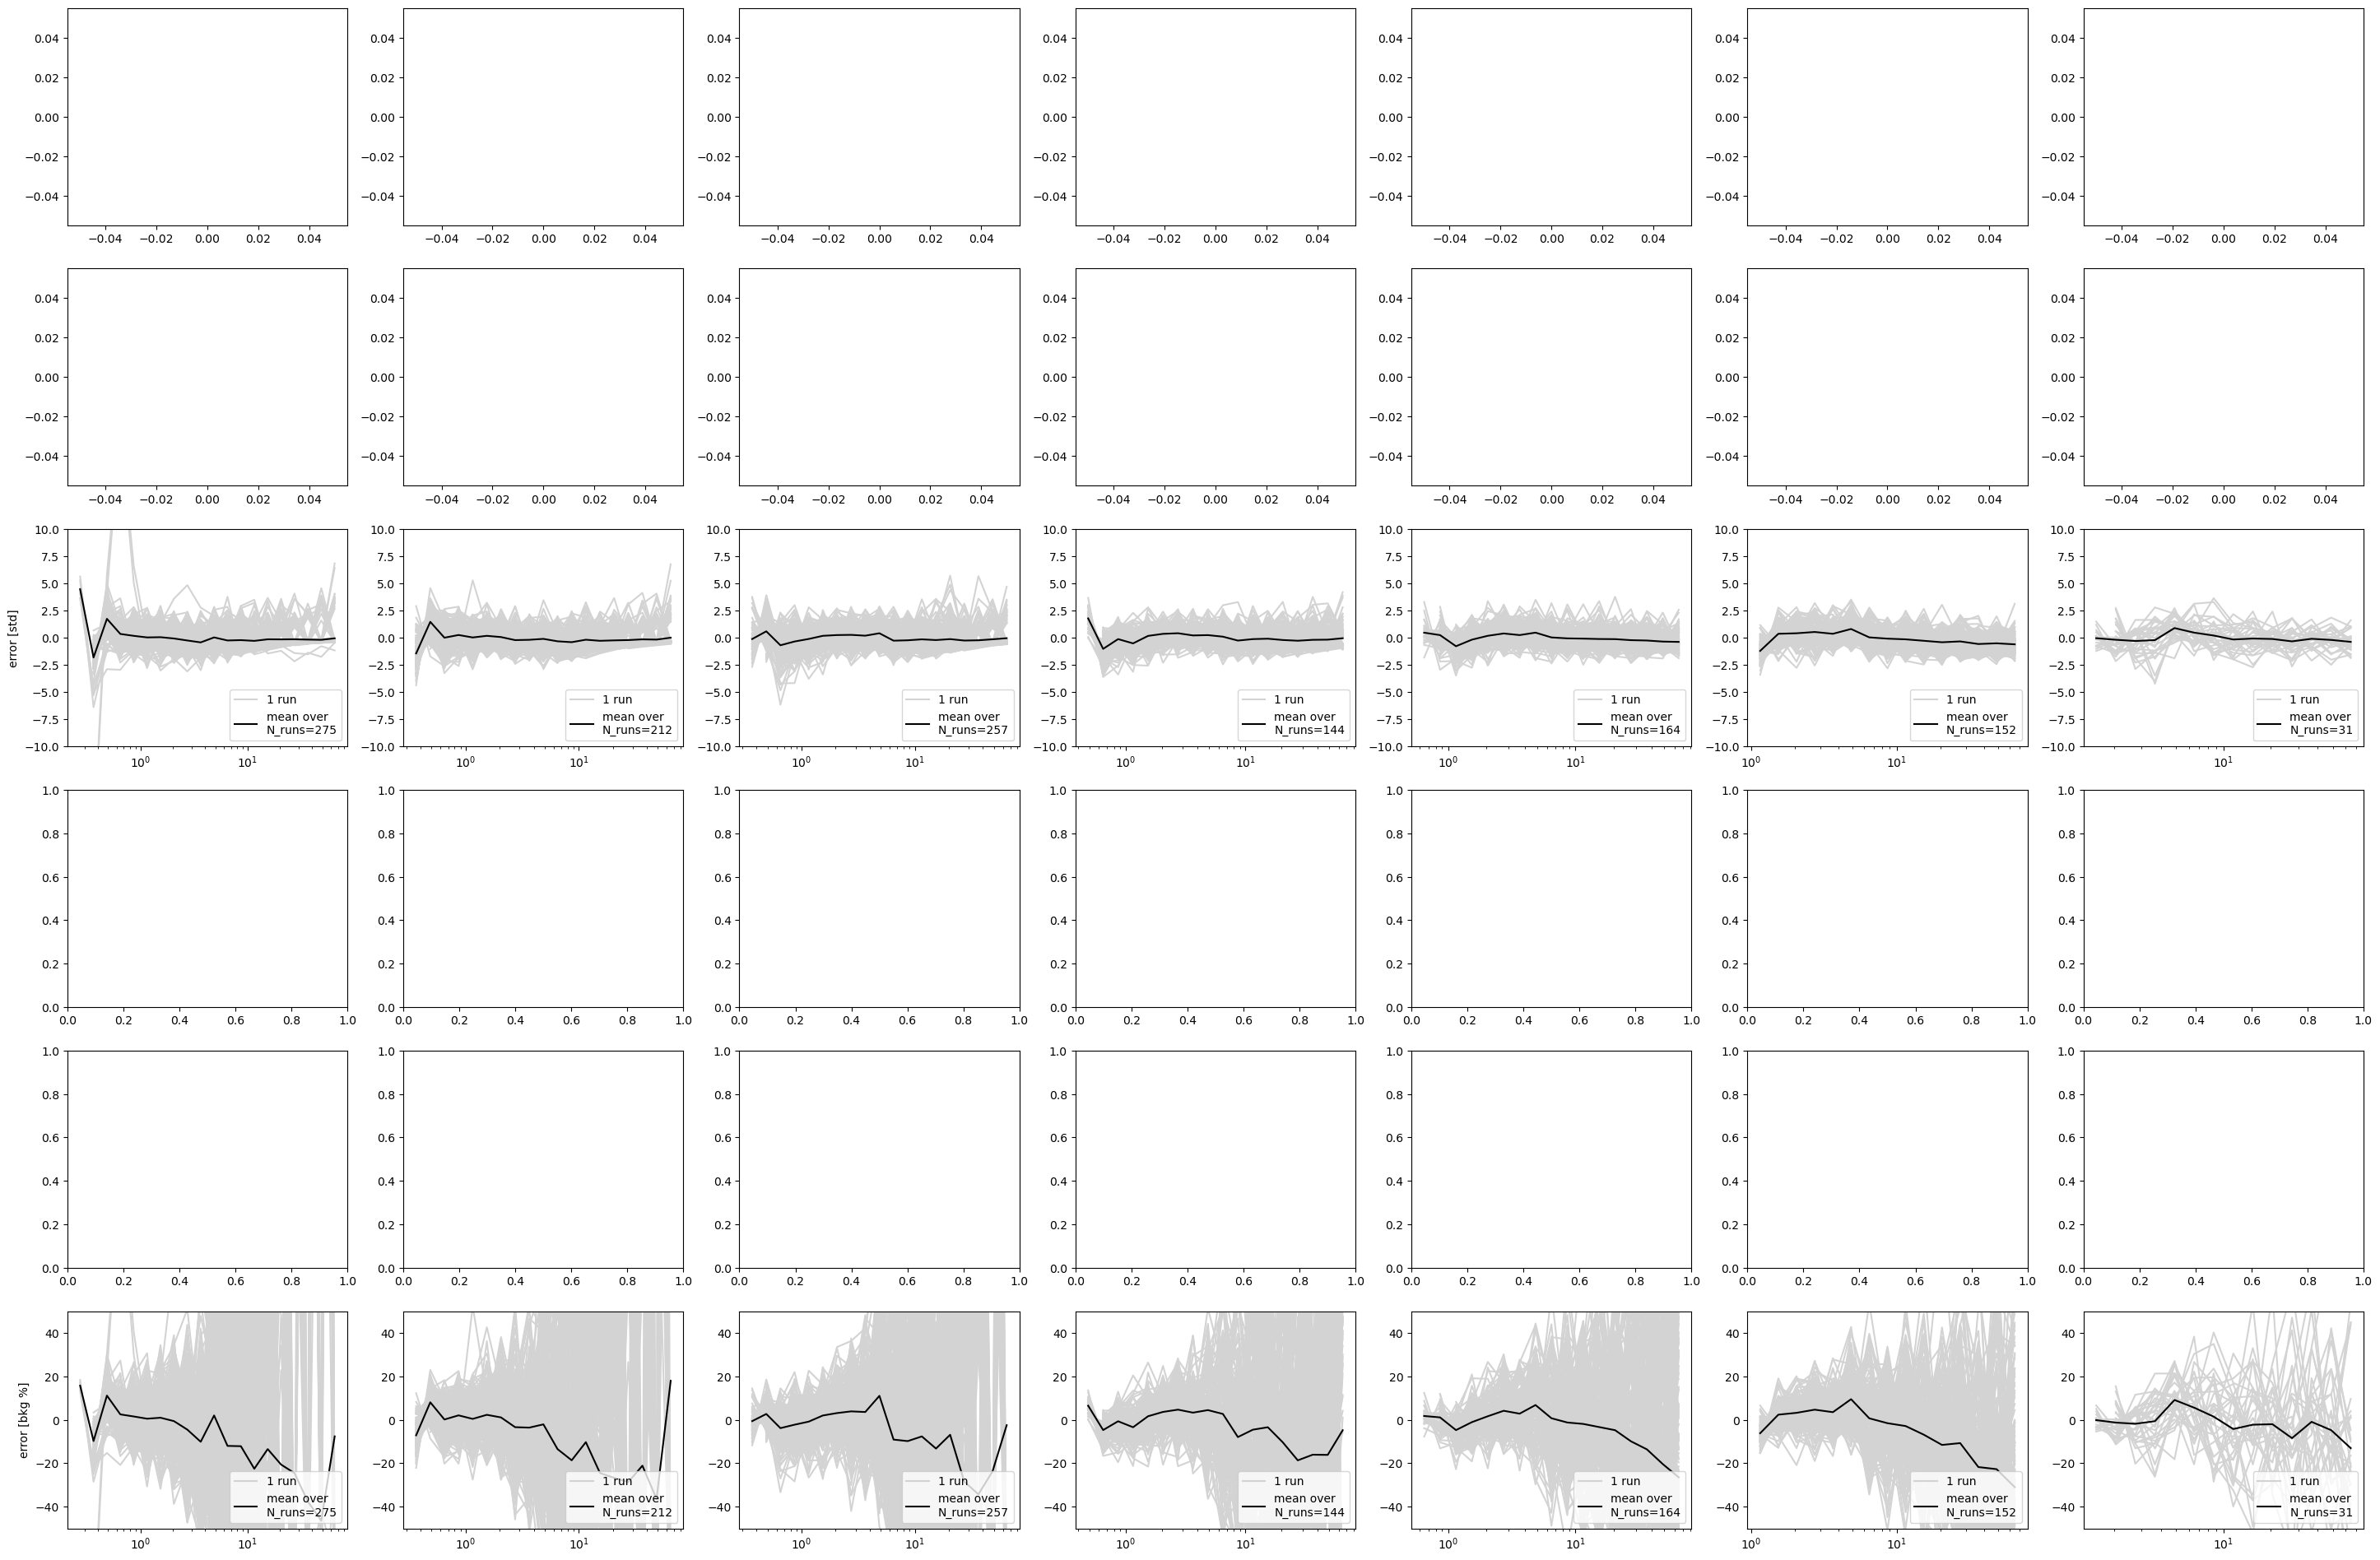

In [11]:
hessera = 'hess2'

muoneff_flag = True
edisp_flag = False
aeff_flag = True
bkg_peak_flag = False

info, error_std, error_percentage = get_results(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)
saving_model(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag, er_est)

plot_lookup_table(er_est)
plot_mean_std(N_est, er_est, std_est)
plot_gray_curves(info, error_std, error_percentage)

In [ ]:
hessera = 'hess1'

muoneff_flag = False
edisp_flag = False
aeff_flag = True
bkg_peak_flag = False

info, error_std, error_percentage = get_results(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)
saving_model(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag, er_est)

plot_lookup_table(er_est)
plot_mean_std(N_est, er_est, std_est)
plot_gray_curves(info, error_std, error_percentage)

In [ ]:
hessera = 'hess1'

muoneff_flag = False
edisp_flag = True
aeff_flag = True
bkg_peak_flag = True

info, error_std, error_percentage = get_results(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)
saving_model(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag, er_est)

plot_lookup_table(er_est)
plot_mean_std(N_est, er_est, std_est)
plot_gray_curves(info, error_std, error_percentage)

In [ ]:
hessera = 'hess2'

muoneff_flag = False
edisp_flag = False
aeff_flag = True
bkg_peak_flag = False

info, error_std, error_percentage = get_results(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)
saving_model(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag, er_est)

plot_lookup_table(er_est)
plot_mean_std(N_est, er_est, std_est)
plot_gray_curves(info, error_std, error_percentage)

In [ ]:
hessera = 'hess2'

muoneff_flag = False
edisp_flag = True
aeff_flag = True
bkg_peak_flag = True

info, error_std, error_percentage = get_results(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)
saving_model(hessera, muoneff_flag, edisp_flag, aeff_flag, bkg_peak_flag, er_est)

plot_lookup_table(er_est)
plot_mean_std(N_est, er_est, std_est)
plot_gray_curves(info, error_std, error_percentage)